In [1]:
"""
Created on Mon Apr 11 20:38:30 2022

@author: jotha
"""
#IMPORT STATEMENTS
import time
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
from tabulate import tabulate
from itertools import chain
from copy import deepcopy
from itertools import permutations
from matplotlib import pyplot as plt

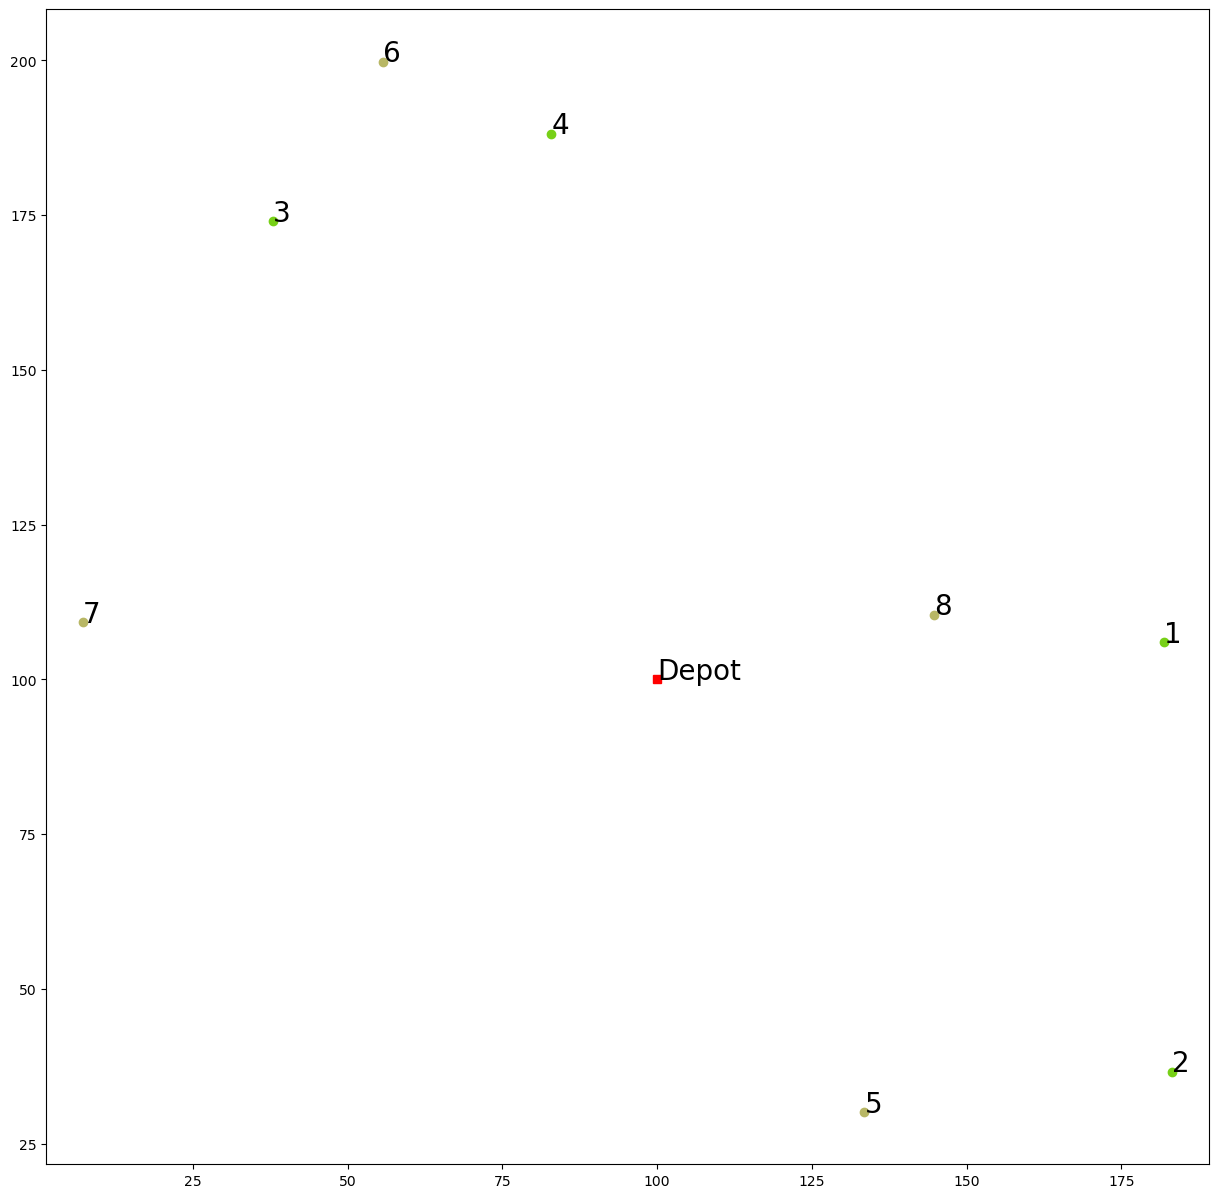

Number Of Farms =  8
Number Of Fertilizers =  2
Number Of Ssprayers =  3


In [2]:
#VRP INITIALIZATION


number_of_colors = 25

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

rnd=np.random
# rnd.seed(0)                        #comment out for random coordinates
n=8                          #number of farms
f=2                                #number of fertilizers
spn=3                                    #number of sprayers
# n = random.randint(10, 25)
# f = random.randint(2, 4)
# spn = random.randint(1, 4)

xc=rnd.rand(n+1)*200               #initiate co-ordinates
yc=rnd.rand(n+1)*200
xc[0]=100
yc[0]=100
xcp=xc[1:]                         
ycp=yc[1:]

splitsx = np.array_split(xcp, f)   #split coordinates based on number of fertilizers
splitsy = np.array_split(ycp, f)   


plt.figure(figsize=(15, 15))

plt.plot(xc[0],yc[0], c='r', marker='s')              #plot depot
for i in range(len(splitsx)):
    plt.scatter(splitsx[i],splitsy[i], c=color[i])    #plot farms with different fertilizer needs in different colors
N=[i for i in range(1,n+1)]                           #set of all farms
for i in N:
    plt.annotate('%d'%(i),(xc[i],yc[i]),fontsize=20)  #annotate farm number
plt.annotate('Depot',(xc[0],yc[0]),fontsize=20)

plt.axis('equal')
plt.show()


print('Number Of Farms = ', n)
print('Number Of Fertilizers = ', f)
print('Number Of Ssprayers = ', spn)




In [3]:
K=[i for i in range(1,spn+1)]

In [4]:
K

[1, 2, 3]

In [5]:
#FERTILIZER TYPE ASSIGNMENT

NO=[]                                    
NO=np.array_split(N, f)
NOP = [list(array) for array in NO]
#print(NOP)
V=[list(array) for array in NO]
for i in range(len(NOP)):
    V[i]=([0]+NOP[i])                   #Set of farms with same fertilizer type
NTOT=[0]+N                              #Set of all farm with depot
F=[]
for i in range(1,f+1):
    F.append(i)
FF=np.array_split(F, f)
FIN = [list(array) for array in FF]    

L=[]
#L = np.array_split(L, f)
for i in range(len(NOP)):
    for j in range(len(NOP[i])):
        L.append((i+1)*0.1)

LGUR={i+1:L[i] for i in range(len(N))}    #Set with farm type and fertilizer type key:value pair

LG = {k: round(v, 1) for k, v in LGUR.items()}

# SET INITIATION

A=[(i,j) for i in NTOT for j in NTOT if i!=j] #arc set
AK = [(i,j,k) for i in NTOT for j in NTOT for k in K if i!=j]
C={(i,j):np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i,j in A}        #Distance between i and j
T={(i,j):C[i,j]*1 for i,j in A}                                  #Time of travel between i and j (change 1 to some other number to increase travel time)
TT=10                                                            #TaNker refill - NOT USED
DT={(i,j):T[i,0]+T[0,j]+TT for i,j in A if i!=0 and j!=0 }       #Tanker refill data - NOT USED
#for j in E:
    #DT[0,j] = 0
#for i in E:
    #DT[i,0] = 0
T[0,0]=0
CS=4                                    #Capacity of sprayer
CT=500                                  #Capacity of tanker
TS=10                                   #Time take to refill sprayer
DEM={i:rnd.randint(2,3)for i in NTOT}   #Demand at each node
DEM[0]=0
SER={i:rnd.randint(20,100)for i in NTOT} #Service Time at each node
SER[0]=0
M=10000                                  
Z=[0]                                    #Depot set


#NODES LIST

lista=[]
for i in range(1,n+1):
    lista.append(i)
start = time.time()
#method goes here
end = time.time()
total_time = end - start
# print("\n Execution time : "+ str(total_time)) #use for time calc of methods
tmax_value=700

In [6]:
# #REFILL LOCATION FUNCTION (MULTI FERTILIZER) FOR SINGLE ROUTE 

#THIS RETURNS UNORDERED ROUTES

def is_nested(lst):
    for item in lst:
        if isinstance(item, list):
            return True
    return False

def inv(tof):
    if tof:
        return False
    return True

start = time.time()
def refillPosition_initial(refill_func_routes,refill_func_dem,refill_func_sprayerCap):
    if inv(is_nested(refill_func_routes)):
        refill_func_routes=[refill_func_routes]
    refillLocations = []
    for i in refill_func_routes:
        remainingCap = refill_func_sprayerCap
        for j in range(1,len(i)-2):
            currentNode = i[j]
            nextVisit = i[j+1]
            remainingCap = remainingCap - refill_func_dem[currentNode]
            if(LG[currentNode]-LG[nextVisit]==0):
                if (remainingCap - refill_func_dem[nextVisit] < 0):
                    refillLocations.append(currentNode)
                    remainingCap = refill_func_sprayerCap
            else:
                refillLocations.append(currentNode)
                remainingCap = refill_func_sprayerCap
                
    return refillLocations

##REFILL LOCATION FUNCTION (MULTI FERTILIZER) FOR ENTIRE SET OF ROUTES

def get_refill_nodes_for_population(population, refill_func_dem, refill_func_sprayerCap):
    refill_nodes_population = [
        refillPosition_initial(route_set, refill_func_dem, refill_func_sprayerCap)
        for route_set in population
    ]
    return refill_nodes_population

def generate_random_solution(nodes, num_sprayers):
    shuffled_nodes = nodes.copy()
    random.shuffle(shuffled_nodes)
    route_lengths = [len(shuffled_nodes) // num_sprayers] * num_sprayers

    for i in range(len(shuffled_nodes) % num_sprayers):
        route_lengths[i] += 1

    shuffled = []
    start = 0
    if len(route_lengths)>1:
        
        for length in route_lengths:
            route = [0] + shuffled_nodes[start:start + length] + [0]
            shuffled.append(route)
            start += length
    
    else:
        
        for length in route_lengths:
            route = [0] + shuffled_nodes[start:start + length] + [0]
            shuffled = route.copy()
            start += length
        
    return shuffled

def refillPosition(refill_func_routes,refill_func_dem,refill_func_sprayerCap):
    rej=refillPosition_initial(refill_func_routes,refill_func_dem,refill_func_sprayerCap)
    bulbasaur = iwant_correct_refill(refill_func_routes,rej)
    return bulbasaur

#DO NOT DELETE - ACCURATE FUNCTION ESTIMATION - WORKS FOR ALL NUMBER OF NODES FERTILIZERS AND SPRAYERS

def all_times_calculation(routes_i,refill_i):
    if inv(is_nested(routes_i)):
        routes_i=[routes_i]
    
    routes = deepcopy(routes_i)
    refill_nodes = refill_i.copy()
    service_completion_times = {}
    refill_completion_times = {}
    refills_order = []
    # STEP 1: Calculate the service completion times of starting nodes
    for route in routes:
        for node in route[1:2]:
            service_completion_times[node] = T[0, node] + SER[node]
    wilma=0
    current_nodes = [route[1] for route in routes]
    
    no_re = 1
    while refill_nodes:
        no_re = 0
        # STEP 2: Determine if all nodes from subroutes are in the refill nodes list

        all_in_refill_nodes = all(node in refill_nodes for node in current_nodes)
        if all_in_refill_nodes:
            # STEP 3: Find the minimum service completion time among the refill nodes
            min_time = float('inf')
            next_refill_node = None
            for node in current_nodes:
                if service_completion_times[node] < min_time:
                    min_time = service_completion_times[node]
                    next_refill_node = node

            # STEP 4: Calculate the refill completion time for the chosen refill node
            if wilma==0:
                refill_completion_times[next_refill_node] = service_completion_times[next_refill_node]+TS
                prev_refill_node = next_refill_node
                wilma +=1
            else:
                refill_completion_times[next_refill_node] = max(service_completion_times[next_refill_node],refill_completion_times[prev_refill_node]+T[prev_refill_node,next_refill_node])+TS
                prev_refill_node = next_refill_node
            refills_order.append(next_refill_node)
            refill_nodes.remove(next_refill_node)

            # STEP 5: Calculate the service completion time for the node that follows the refill node in the subroute

            for i, route in enumerate(routes):
                if next_refill_node in route:
                    next_node_index = route.index(next_refill_node) + 1
                    if next_node_index < len(route):
                        next_node = route[next_node_index]
                        if next_node != next_refill_node:
                            service_completion_times[next_node] = refill_completion_times[next_refill_node] + T[next_refill_node,next_node] + SER[next_node] 
                            current_nodes[i] = next_node
        else:
            # STEP 6: Continue calculating service completion times for the subroutes that have not yet reached a refill node
            i = 0
            while i < len(routes):
                route = routes[i]
                current_node = current_nodes[i]
                if current_node not in refill_nodes:
                    next_node_index = route.index(current_node) + 1
                    if next_node_index < len(route):
                        next_node = route[next_node_index]
                        if next_node == 0:  # If the next node is 0, remove the route from current_nodes
                            current_nodes.pop(i)
                            routes.pop(i)
                        else:
                            service_completion_times[next_node] = service_completion_times[current_node] + T[current_node, next_node] + SER[next_node]
                            current_nodes[i] = next_node
                            i += 1
                    else:
                        i += 1
                else:
                    i += 1
    if no_re!=0:
        i = 0
        no_re=1
        while i < len(routes):
            route = routes[i]
            current_node = current_nodes[i]
            if current_node not in refill_nodes:
                next_node_index = route.index(current_node) + 1
                if next_node_index < len(route):
                    next_node = route[next_node_index]
                    if next_node == 0:  # If the next node is 0, remove the route from current_nodes
                        current_nodes.pop(i)
                        routes.pop(i)
                    else:
                        service_completion_times[next_node] = service_completion_times[current_node] + T[current_node, next_node] + SER[next_node]
                        current_nodes[i] = next_node
                        i += 1
                else:
                    i += 1
            else:
                i += 1
    if no_re==0:
        while next_node!=0:
            this_node = next_node
            next_node_index = routes[0].index(this_node) + 1
            next_node=routes[0][next_node_index]
            service_completion_times[next_node] = service_completion_times[this_node] + T[this_node, next_node] + SER[next_node]

    service_completion_times[0]=0
    
    sorted_dict = sorted(service_completion_times.items(), key=lambda item: item[1], reverse=True)[:spn]
    result_list = [T[key,0] + value for key, value in sorted_dict]
    late_depot=max(result_list)
    if late_depot > tmax_value:
        latest_arrival_at_depot = 100000
    else:
        latest_arrival_at_depot = late_depot
    return latest_arrival_at_depot, refills_order, service_completion_times, refill_completion_times



In [7]:
all_times_calculation(shuffled, re)


NameError: name 'shuffled' is not defined

In [8]:

def swap(routes):
    route_indices = random.sample(range(len(routes)), 2)
    route1 = routes[route_indices[0]]
    route2 = routes[route_indices[1]]
    i = random.randint(1, len(route1) - 2)
    j = random.randint(1, len(route2) - 2)
    route1[i], route2[j] = route2[j], route1[i]
    return routes

def insertion(route):
    if len(route) <= 3:
        return route

    i, j = random.sample(range(1, len(route) - 1), 2)
    temp = route.pop(i)
    route.insert(j, temp)
    return route

def inversion(route):
    if len(route) <= 3:
        return route

    i, j = sorted(random.sample(range(1, len(route) - 1), 2))
    route[i:j+1] = reversed(route[i:j+1])
    return route

def mutate(routes):
    if inv(is_nested(routes)):
        routes=[routes]
        
    mutation_func = random.choice([insertion, inversion])
    mutated_routes = [mutation_func(route) for route in routes]
    
    if len(routes) > 1:
        if random.random() < mutation_rate:
            mutated_routes = swap(mutated_routes)
        elif random.random() < mutation_rate:
            mutated_routes = swap(mutated_routes)
    
    return mutated_routes

#WORKING FLATTENED CORSSOVER - DO NOT DELETE


def crossover_multisprayer(route1,route2):

    l1=[]
    l2=[]
    for i in route1:
        l1.append(len(i)-2)
    for i in route2:
        l2.append(len(i)-2)

    flat_parent1=([node for subroute in route1 for node in subroute if node!=0])
    flat_parent2=([node for subroute in route2 for node in subroute if node!=0])

    lista = [i for i in flat_parent1 if i!=0]
    listb = [i for i in flat_parent2 if i!=0]
    

    half_length = (len(flat_parent1))//2

    cc1=flat_parent1[:half_length]
    cc2=flat_parent2[half_length:]

    for i in  cc1:
        if i in cc2:
            cc2.remove(i)
    new_child1 = cc1+cc2

    for i in listb:
        if i not in new_child1:
            new_child1.append(i)

    newest_child1 = []
    start_index = 0

    for size in l1:
        sublist1 = [0]+new_child1[start_index:start_index+size]+[0]
        newest_child1.append(sublist1)
        start_index += size

        
    lista = [i for i in flat_parent1 if i!=0]    
    listb = [i for i in flat_parent2 if i!=0]
    

    half_length = (len(flat_parent2))//2

    cc1=flat_parent2[:half_length]
    cc2=flat_parent1[half_length:]

    for i in  cc1:
        if i in cc2:
            cc2.remove(i)
    new_child2 = cc1+cc2

    for i in lista:
        if i not in new_child2:
            new_child2.append(i)

    newest_child2 = []
    start_index = 0

    for size in l2:
        sublist2 = [0]+new_child2[start_index:start_index+size]+[0]
        newest_child2.append(sublist2)
        start_index += size
        
    return newest_child1,newest_child2


def crossover_single_spray(route1,route2):
    flat_parent1=([node for node in route1])
    flat_parent2=([node for node in route2])

    zz=0
    for i in flat_parent1:
        if i == 0:
            zz+=1
    if zz == 2:
        half_length = (len(flat_parent1))//2
    half_length

    lista = [i for i in flat_parent1 if i!=0]
    listb = [i for i in flat_parent2 if i!=0]
    

    cc1=flat_parent1[1:half_length]
    cc2=flat_parent2[half_length:-1]

    for i in  cc1:
        if i in cc2:
            cc2.remove(i)
    
    new_child1 = cc1+cc2

    for i in listb:
        if i not in new_child1:
            new_child1.append(i)
    
    new_child1=[0]+new_child1+[0]
    
    zz=0
    for i in flat_parent2:
        if i == 0:
            zz+=1
    if zz == 2:
        half_length = (len(flat_parent2))//2
    half_length

    lista = [i for i in flat_parent1 if i!=0]
    listb = [i for i in flat_parent2 if i!=0]
    

    cc1=flat_parent2[1:half_length]
    cc2=flat_parent1[half_length:-1]

    for i in  cc1:
        if i in cc2:
            cc2.remove(i)
    
    new_child2 = cc1+cc2

    for i in lista:
        if i not in new_child2:
            new_child2.append(i)
    
    new_child2=[0]+new_child2+[0]

    
    return new_child1,new_child2


def crossover(parent1, parent2):
    if is_nested(parent1):
        child1,child2 = crossover_multisprayer(parent1,parent2)
    else:
        child1,child2 = crossover_single_spray(parent1,parent2)
    
    return child1,child2
    

def perform_evolution(population, mutation_rate, crossover_rate):
    new_population = []

    while len(new_population) < len(population):
        parent1 = random.choice(population)
        parent2 = random.choice(population)

        if random.random() < crossover_rate:
            child1, child2 = crossover(parent1, parent2)
        else:
            child1, child2 = parent1, parent2

        if random.random() < mutation_rate:
            child1 = mutate(child1)
        if random.random() < mutation_rate:
            child2 = mutate(child2)

        new_population.append(child1)
        new_population.append(child2)

    return new_population

#ROUTE GENERATION TYPES

def generate_random_popfrmroute(route,population_number):
    if inv(is_nested(route)):
        route=[route]
    new_pop = []
    for _ in range(population_number):   
        new_ro = [[] for _ in route]
        len_max = get_max_route_l(route) 
        node_reser=[]
        for i in route:
            for j in i:
                node = j
                if j!=0:
                    node_reser.append(j)

        for i in range(len(new_ro)):
            for j in range(len_max):
                if len(new_ro[i])<(len_max-2) and node_reser:
                    random_node = random.choice(node_reser)

                    new_ro[i].append(random_node)
                    node_reser.remove(random_node)

        for i in new_ro:
            i.append(0)
            i.insert(0,0)   

        new_pop.append(new_ro)
    return new_pop

def get_max_route_l(route):
    if inv(is_nested(route)):
        route=[route]
    ma = []
    for i in route:
        ma.append(len(i))

    max_route_l = max(ma)
    return max_route_l

def generate_parent_population(initial_routes, population_size):
    if inv(is_nested(initial_routes)):
        initial_routes=[initial_routes]
    population = []
    num_vehicles = len(initial_routes)
    nodes = set([node for subroute in initial_routes for node in subroute[1:-1]])

    for _ in range(population_size):
        new_routes = [[] for _ in range(num_vehicles)]
        remaining_nodes = nodes.copy()

        # Distribute nodes to each subroute
        for i, subroute in enumerate(initial_routes):
            if len(new_routes)<len(subroute):
                subroute_nodes = set(subroute[1:-1])
                available_nodes = remaining_nodes - subroute_nodes
                if not available_nodes:
                    available_nodes = subroute_nodes
                node = random.choice(list(available_nodes))
                new_routes[i].append(0)
                new_routes[i].append(node)
                remaining_nodes.remove(node)

        # Add remaining nodes to subroutes randomly
        for node in list(remaining_nodes):
            subroute_index = random.randint(0, num_vehicles - 1)
            new_routes[subroute_index].insert(-1, node)

        # Add end node to each subroute
        for subroute in new_routes:
            subroute.append(0)

        population.append(new_routes)

    return population


def generate_perturbed_population(initial_routes, population_size):
    population = [initial_routes]
    for _ in range(population_size - 1):
        mutated_routes = copy.deepcopy(initial_routes)
        if len(mutated_routes) > 1:
            mutated_routes = swap(mutated_routes)
        else:
            mutated_routes = mutate(mutated_routes) # Pass the list containing the single route
        population.append(mutated_routes)
    return population


def the_fitness(initial_routes):
    current_solution = initial_routes
    current_rnode = refillPosition_initial(initial_routes,DEM,CS)
    current_fitness,arrival_fitness = combined_fitness(current_solution,current_rnode)
    return current_fitness,arrival_fitness



def tournament_selection(population, fitnesses, k=2):
    selected_indices = random.sample(range(len(population)), k)
    selected_fitnesses = [fitnesses[i] for i in selected_indices]
    best_index = selected_indices[selected_fitnesses.index(min(selected_fitnesses))]
    return population[best_index]

def combined_fitness(current_solution,current_rnode):
    arrival_fitness,correct_r_order,_,_ = all_times_calculation(current_solution,current_rnode)
    node_length_fitness = len(correct_r_order)
    current_fitness = scaled_combined_fitness(arrival_fitness,node_length_fitness)
    return current_fitness,arrival_fitness

def genetic_algorithm(initial_routes, population_size, mutation_rate, crossover_rate, num_generations, DEM,CS):
    genetic_his_lis=[]
    population = generate_perturbed_population(initial_routes, population_size)
#     population = generate_parent_population(initial_routes, population_size) #USE THIS FOR MORE RANDOMIZED ROUTES

    for gen in range(num_generations):
        new_population = perform_evolution(population, mutation_rate, crossover_rate)
#         refill_nodes_population = get_refill_nodes_for_population(new_population, DEM,CS)

        fitnesses = [
            the_fitness(route_set)[0]
            for route_set in new_population
        ]

        # Tournament selection
        selected_population = [
            tournament_selection(new_population, fitnesses)
            for _ in range(population_size)
        ]

        population = selected_population
        his_fit = [
            the_fitness(route_set)[1]
            for route_set in population
        ]
        
        genetic_his_lis.append(min(his_fit))
        

    best_route_index = fitnesses.index(min(fitnesses))
    best_route = population[best_route_index]
    best_route_refill_nodes_i = refillPosition_initial(best_route,DEM,CS)
    best_fitness,best_route_refill_nodes,_,_ = all_times_calculation(best_route,best_route_refill_nodes_i)
    
    return best_route, best_route_refill_nodes, best_fitness, genetic_his_lis



def perturb_solution(solution):
    if inv(is_nested(solution)):
        solution=[solution]
    new_solution = [route.copy() for route in solution]
    
    if len(new_solution) > 1:
        route1_index, route2_index = random.sample(range(len(new_solution)), 2)
        node1_index = random.randint(1, len(new_solution[route1_index]) - 2)
        node2_index = random.randint(1, len(new_solution[route2_index]) - 2)

        new_solution[route1_index][node1_index], new_solution[route2_index][node2_index] = \
            new_solution[route2_index][node2_index], new_solution[route1_index][node1_index]
    else:
        mutation_func = random.choice([insertion, inversion])
        new_solution[0] = mutation_func(new_solution[0])

    return new_solution


#SIMULATED ANNEALING MAIN FUNCTION FOR INITIAL SOLUTION

def simulated_annealing(initial_routes, DEM, CS, refillPosition, all_times_calculation, initial_temperature, cooling_factor, iteration_limit):
    sim_fit_his = []
    current_solution = initial_routes
    current_fitness = the_fitness(current_solution)[0]

    best_solution = current_solution
    best_fitness = current_fitness

    temperature = initial_temperature

    for iteration in range(iteration_limit):
        new_solution = perturb_solution(current_solution)
        new_rnode = refillPosition(new_solution,DEM,CS)
        new_fitness = the_fitness(new_solution)[0]


        if new_fitness < current_fitness or should_accept_solution(current_fitness, new_fitness, temperature):
            current_solution = new_solution
            current_fitness = new_fitness

            if new_fitness < best_fitness:
                best_solution = new_solution
                best_fitness = new_fitness
                best_tru_fit = the_fitness(best_solution)[1]
                sim_fit_his.append(best_tru_fit)
                
        
        temperature *= cooling_factor

    return best_solution,sim_fit_his

#ACCEPTANCE CRITERIA FOR SIMULATED ANNEALING

def should_accept_solution(current_fitness, new_fitness, temperature):
    if new_fitness < current_fitness:
        return True
    return random.random() < math.exp((current_fitness - new_fitness) / temperature)

def create_start_route(starting_solution):
    initial_solution=[]
    for route in starting_solution:
        for i in range(len(route) - 1):
            initial_solution.append((route[i], route[i + 1]))
    return initial_solution

def create_route_pairs(reordered_list):
    route_pairs = []
    
    # Add route from 0 to the first node and from the last node back to 0
    route_pairs.append((0, reordered_list[0]))
    route_pairs.append((reordered_list[-1], 0))

    # Add routes between consecutive nodes in the reordered_list
    for i in range(len(reordered_list) - 1):
        route_pairs.append((reordered_list[i], reordered_list[i + 1]))

    return route_pairs

def convert_routes(routes_with_depots):
    converted_routes = []
    for route in routes_with_depots:
        # Remove the depots (0) from the route
        route_without_depots = [node for node in route if node != 0]
        
        # Convert the route into pairs of nodes
        converted_route = [(route_without_depots[i], route_without_depots[i+1]) for i in range(len(route_without_depots)-1)]
        converted_routes.extend(converted_route)  # Use extend instead of append to flatten the list
    return converted_routes

def nn_test(routes):
    nn_r_F = refillPosition_initial(routes,DEM,CS)
    nn_f_F,nn_or_F,_,_ = all_times_calculation(routes,nn_r_F)
    return nn_f_F



def scaled_combined_fitness(arrival_time,length_of_refill):

    # Define the scaling factors for each fitness function
    scaling_factor1 = 1 / 300  # You can adjust this value based on the importance of fitness1
    scaling_factor2 = 1 / 5    # You can adjust this value based on the importance of fitness2

    # Scale the fitness values
    scaled_fitness1 = arrival_time * scaling_factor1
    scaled_fitness2 = length_of_refill * scaling_factor2

    # Combine the scaled fitness values using a weighted sum
    combined_fitness = 0.8 * scaled_fitness1 + 0.2 * scaled_fitness2
    
    return combined_fitness

def calculate_distance(route1, route2):
    if inv(is_nested(route1)):
        route1=[route1]
    if inv(is_nested(route2)):
        route2=[route2]
    # Flatten the routes
    route1_flat = [node for subroute in route1 for node in subroute]
    route2_flat = [node for subroute in route2 for node in subroute]

    # Initialize the distance
    distance = 0

    # Calculate the sum of the differences in the order of visiting nodes
    for node in set(route1_flat + route2_flat):
        if node != 0:  # Exclude the depot
            position1 = route1_flat.index(node)
            position2 = route2_flat.index(node)
            distance += abs(position1 - position2)

    return distance


In [9]:
def generate_ant_route(pheromones, heuristic, alpha, beta):
    num_nodes = max(max(i, j) for i, j in pheromones.keys()) +1
    num_vehicles = spn
    unvisited_nodes = set(range(1, num_nodes))
    ant_routes = [[] for _ in range(num_vehicles)]
    route_lengths = [num_nodes // spn] * spn

    for i in range(num_nodes % spn):
        route_lengths[i] += 1
    route_lengths

    for vehicle in range(num_vehicles):
        current_node = 0
        while unvisited_nodes:
            # Calculate the probability of visiting each remaining node
            probabilities = []
            for next_node in unvisited_nodes:
                probability = (pheromones[current_node, next_node] ** alpha) * (heuristic[current_node, next_node] ** beta)
                probabilities.append(probability)
            # Normalize the probabilities
            probabilities = np.array(probabilities)
            probabilities /= probabilities.sum()
            # Select the next node probabilistically
            next_node = np.random.choice(list(unvisited_nodes), p=probabilities)

            # Add the selected node to the vehicle's route and remove it from the list of unvisited nodes
            ant_routes[vehicle].append(next_node)
            unvisited_nodes.remove(next_node)
            if len(ant_routes[vehicle])>=route_lengths[vehicle]:
                ant_routes[vehicle].insert(0, 0)
                ant_routes[vehicle].append(0)
                break
            if len(unvisited_nodes) ==0:
                ant_routes[vehicle].insert(0, 0)
                ant_routes[vehicle].append(0)
            # Update the current node
            current_node = next_node
    return ant_routes

def evaporate_pheromones(pheromones, evaporation_rate):
    updated_pheromones = pheromones.copy()
    for key in updated_pheromones:
        updated_pheromones[key] *= (1 - evaporation_rate)
    return updated_pheromones

def update_pheromones(pheromones, ant_routes, fitness_values, delta):
    updated_pheromones = pheromones.copy()
    for idx, routes in enumerate(ant_routes):
        fitness = 10/fitness_values[idx]
        for route in routes:
            for i in range(len(route) - 1):
                updated_pheromones[route[i], route[i + 1]] += delta / fitness
    return updated_pheromones


In [10]:

# Main loop

def ant_colony_optimization():
    initial_pheromone = 0.5
    ant_hist=[]
    # Initialize pheromone trails
    pheromones = {}
    for i in range(n+1):  
        for j in range(n+1):
            if i != j:
                pheromones[(i, j)] = initial_pheromone

    # Initialize heuristic information
    non_incorp_heuristic = {}
    for i in range(n+1):  
        for j in range(n+1):
            if i != j:
                non_incorp_heuristic[(i, j)] = 5 / T[i, j]

    heuristic = {}
    for i in range(n+1):  
        for j in range(n+1):
            if i != j:
                heuristic[(i, j)] = 3 /( T[i, j])


    for iteration in range(num_iterations):

        # 1. Generate a population of ants (routes) based on the pheromone trails and heuristic information
        ant_routes = []
        for ant in range(num_ants):
            route = generate_ant_route(pheromones, heuristic, alpha, beta)
            ant_routes.append(route)

#         fitness_values = [ant_colony_fitness(route) for route in ant_routes]
        
        fitness_values = []
        second_values = []

        for route in ant_routes:
            fitness, second_value = the_fitness(route)
            fitness_values.append(fitness)
            second_values.append(second_value)

        pheromones = update_pheromones(pheromones, ant_routes, fitness_values,delta)

        # 4. Apply evaporation to the pheromone trails
        pheromones = evaporate_pheromones(pheromones, rho)
        ant_hist.append(min(second_values))
    antc_route = min(zip(ant_routes, fitness_values), key=lambda x: x[1])[0]
    min_value=min(fitness_values)
    return antc_route,ant_hist
         





In [11]:
def continuous_to_discrete(particle, num_nodes, num_vehicles):
    routes = [[] for _ in range(num_vehicles)]

    # Convert the continuous particle into a sequence of nodes
    node_sequence = sorted(range(1, num_nodes + 1), key=lambda i: particle[i - 1])

    # Distribute the nodes among the vehicles
    vehicle_idx = 0
    for node in node_sequence:
        routes[vehicle_idx].append(node)
        vehicle_idx = (vehicle_idx + 1) % num_vehicles

    # Add the depot at the beginning and end of each route
    for route in routes:
        route.insert(0, 0)
        route.append(0)

    return routes

# continuous_to_discrete(particles[0], num_nodes, spn)


In [12]:

def particle_swarm(num_particles):
    num_particles = num_particles
    num_nodes = len(N)  # 0 is the depot, and nodes
    num_edges = (num_nodes + 1) * num_nodes  # including the depot

    # Initialize the particles
    particles = np.random.rand(num_particles, num_edges)

    velocities = np.random.rand(num_particles, num_edges) * 0.1  # initialize with small random values

    personal_best_positions = particles.copy()
    personal_best_fitness = np.full(num_particles, float('inf'))
    global_best_position = None
    global_best_fitness = float('inf')



    num_iterations = 50
    w = 1  # Inertia weight
    c1 = 6  # Cognitive coefficient
    c2 = 20  # Social coefficient
    part_hist_list=[]
    for iteration in range(num_iterations):
        for idx, particle in enumerate(particles):
            # Evaluate the fitness of the particle
            route = continuous_to_discrete(particle, num_nodes, spn)
            fitness,part_hist = the_fitness(route)


            # Update personal best
            if fitness < personal_best_fitness[idx]:
                personal_best_fitness[idx] = fitness
                personal_best_positions[idx] = particle

            # Update global best
            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_position = particle
                part_hist_list.append(part_hist)

        # Update the particle velocities and positions
        for idx, particle in enumerate(particles):
            r1 = np.random.rand(num_edges)
            r2 = np.random.rand(num_edges)
            cognitive = c1 * r1 * (personal_best_positions[idx] - particle)
            social = c2 * r2 * (global_best_position - particle)
            velocities[idx] = w * velocities[idx] + cognitive + social
            particles[idx] += velocities[idx]

    partice_swarm_fitness=[]
    particle_swarm_solution=[]
    for i in range(len(particles)):    
        particle_swarm_solution.append(continuous_to_discrete(particles[i], num_nodes, spn))
        pp_re = refillPosition_initial(particle_swarm_solution[i],DEM,CS)
        pp_f,pp_rrr,_,_ = all_times_calculation(particle_swarm_solution[i],pp_re)
        partice_swarm_fitness.append(pp_f)
    
    particle_swarm_solution
    particle_fitness=min(partice_swarm_fitness)
    
    part_sol_idx = partice_swarm_fitness.index(particle_fitness)
    
    particle_swarm_solution=particle_swarm_solution[part_sol_idx]
    
    return particle_swarm_solution,particle_fitness,part_hist_list
        

In [13]:


def generate_neighbors(solution):
    if inv(is_nested(solution)):
        solution=[solution]
    neighbors = []

    for _ in range(5000):  # Generate 10 neighbors
        # Choose a random route and two random nodes within the route
        route = random.choice(solution)
        i, j = random.sample(range(1, len(route) - 1), 2)  # Exclude the depot nodes

        # Create a new neighbor by swapping the two nodes
        neighbor = [list(r) for r in solution]  # Make a copy of the solution
        neighbor_route = neighbor[solution.index(route)]  # Get the corresponding route in the neighbor
        neighbor_route[i], neighbor_route[j] = neighbor_route[j], neighbor_route[i]

        neighbors.append(neighbor)

    return neighbors

def swap_nodes_between_routes(solution):
    if inv(is_nested(solution)):
        solution=[solution]
    neighbors = []

    for _ in range(5000):  # Generate 10 neighbors
        # Choose two random routes
        route1, route2 = random.sample(solution, 2)

        # Choose a random node within each route
        i = random.choice(range(1, len(route1) - 1))  # Exclude the depot nodes
        j = random.choice(range(1, len(route2) - 1))  # Exclude the depot nodes

        # Create a new neighbor by swapping the two nodes
        neighbor = [list(r) for r in solution]  # Make a copy of the solution
        neighbor_route1 = neighbor[solution.index(route1)]  # Get the corresponding route in the neighbor
        neighbor_route2 = neighbor[solution.index(route2)]  # Get the corresponding route in the neighbor
        neighbor_route1[i], neighbor_route2[j] = neighbor_route2[j], neighbor_route1[i]

        neighbors.append(neighbor)

    return neighbors

def move_node_within_route(solution):
    if inv(is_nested(solution)):
        solution=[solution]
    neighbors = []

    for _ in range(5000):  # Generate 10 neighbors
        # Choose a random route
        route = random.choice(solution)

        # Choose two random positions within the route
        i, j = random.sample(range(1, len(route) - 1), 2)  # Exclude the depot nodes

        # Create a new neighbor by moving the node
        neighbor = [list(r) for r in solution]  # Make a copy of the solution
        neighbor_route = neighbor[solution.index(route)]  # Get the corresponding route in the neighbor
        node = neighbor_route.pop(i)
        neighbor_route.insert(j, node)

        neighbors.append(neighbor)

    return neighbors

def two_opt(solution):
    if inv(is_nested(solution)):
        solution=[solution]
    neighbors = []

    for _ in range(5000):  # Generate 10 neighbors
        # Choose a random route
        route = random.choice(solution)

        # Choose two random positions within the route
        i, j = sorted(random.sample(range(1, len(route) - 1), 2))  # Exclude the depot nodes

        # Create a new neighbor by reversing the order of the nodes between i and j
        neighbor = [list(r) for r in solution]  # Make a copy of the solution
        neighbor_route = neighbor[solution.index(route)]  # Get the corresponding route in the neighbor
        neighbor_route[i:j+1] = reversed(neighbor_route[i:j+1])

        neighbors.append(neighbor)

    return neighbors


def combine_solutions(solution1, solution2, weight):
    # Initialize the new solution
    new_solution = [list(route) for route in solution1]  # Make a copy of solution1

    # Choose a random route and two random nodes within the route
    route_index = random.randint(0, len(new_solution) - 1)
    node_index1, node_index2 = random.sample(range(1, len(new_solution[route_index]) - 1), 2)  # Exclude the depot nodes

    # Swap the nodes with a probability proportional to the weight
    if random.random() < weight:
        new_solution[route_index][node_index1], new_solution[route_index][node_index2] = new_solution[route_index][node_index2], new_solution[route_index][node_index1]

    return new_solution



In [46]:

def tabu_search(initial_solution, fitness, max_iterations, min_tabu_tenure, max_tabu_tenure):
    tabu_fit_hist=[]
    avoid = 1
    if inv(is_nested(initial_solution)):
        initial_solution=[initial_solution]
        avoid = 0
    
    # Initialize the best solution found so far and its fitness
    best_solution = initial_solution
    best_fitness,f_val = fitness(shuffled)
    best_cval = f_val
    
    # Initialize the current solution and its fitness
    current_solution = initial_solution
    current_fitness = best_fitness

    # Initialize the tabu list and its tenure
    tabu_list = []
    tabu_tenure = min_tabu_tenure
    a=1
    b=1
    c=1
    d=1

    for iteration in range(max_iterations):
        # Generate all neighbors of the current solution
        option = [1, 2, 3, 4]

        cho = random.choices(option, weights=(a, b, c, d), k=1)
        if cho[0] == 1:
            neighbors = generate_neighbors(current_solution)
        elif cho[0] == 2:
            neighbors = two_opt(current_solution)
        elif cho[0] == 3:
            neighbors = move_node_within_route(current_solution)
        elif cho[0] == 4 and avoid !=0:
            neighbors = swap_nodes_between_routes(current_solution)
        
        if len(neighbors) == 0:
            continue  # Skip this iteration if the neighbors list is empty


        # Filter out neighbors that are in the tabu list, unless they meet the aspiration criterion
        neighbors = [neighbor for neighbor in neighbors if neighbor not in tabu_list or fitness(neighbor)[0] < best_fitness]
        # Select the best neighbor (i.e., the one with the lowest fitness)
        

        best_neighbor = min(neighbors, key=fitness)


        # Update the current solution and its fitness
        current_solution = best_neighbor
        current_fitness,c_val = fitness(best_neighbor)

        # Update the best solution found so far and its fitness
        if current_fitness < best_fitness:
            best_solution = current_solution
            best_fitness = current_fitness
            best_cval = c_val
            tabu_fit_hist.append(c_val)
            if cho[0] == 1:
                a+=0.5
                b-=0.01
                c-=0.01
                d-=0.01
            elif cho[0] == 2:
                b+=0.5
                a-=0.01
                c-=0.01
                d-=0.01
            elif cho[0] == 3:
                c+=0.5
                a-=0.01
                b-=0.01
                d-=0.01
            elif cho[0] == 4:
                d+=0.5
                a-=0.01
                c-=0.01

        # Update the tabu list
        tabu_list.append(current_solution)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        # Update the tabu tenure based on the progress of the search
        if current_fitness < best_fitness:
            tabu_tenure = min(tabu_tenure + 1, max_tabu_tenure)
        else:
            tabu_tenure = max(tabu_tenure - 1, min_tabu_tenure)

    return best_solution,best_cval,tabu_fit_hist

In [15]:
def gravity_search(initial_solution, population_number,fitness): 
    gsa_population = generate_random_popfrmroute(initial_solution,population_number)
    G=100
    max_iter = 500
    iteration=1
    fitness_gsa_intial=[]
    fitness_record=[]
    cons=0.001
    for i in gsa_population:
        fitness_gsa_intial.append(fitness(i)[0])

    pairs_ini = zip(gsa_population, fitness_gsa_intial)

        # Sort the pairs based on the values of b in ascending order
    sorted_pairs_intial = sorted(pairs_ini, key=lambda x: x[1])

    best_route = sorted_pairs_intial[0][0]
    best_fitness = sorted_pairs_intial[0][1]

    for i in range(max_iter):

        distance_gsa=[[] for _ in range(len(gsa_population))]
        for i in range(len(gsa_population)):
            for j in range(len(gsa_population)):
                distance_gsa[i].append(calculate_distance(gsa_population[i],gsa_population[j]))   

        mass_gsa = []
        for i in gsa_population:
            mass_gsa.append(1/fitness(i)[0])

        F_gsa=[[] for _ in range(len(gsa_population))]
        for i in range(len(gsa_population)):
            for j in range(len(gsa_population)):
                if distance_gsa[i][j] == 0:
                    F_gsa[i].append(0)
                else:    
                    F_gsa[i].append(G * (mass_gsa[i] * mass_gsa[j] / distance_gsa[i][j]))

        F_tot_gsa=[]
        for i in F_gsa:
            F_tot_gsa.append(sum(i))

        total_gsa = sum(F_tot_gsa) 

        prob_gsa=[]
        for i in F_tot_gsa:
            prob_gsa.append(i/total_gsa)

        fitness_gsa = []
        for i in gsa_population:
            fitness_gsa.append(fitness(i)[0])

        remain_gsa_idx = len(gsa_population)//7

        pairs = zip(gsa_population, fitness_gsa)

        # Sort the pairs based on the values of b in ascending order
        sorted_pairs = sorted(pairs, key=lambda x: x[1])


        # Get the smallest 3 values and their corresponding values of a
        smallest = sorted_pairs[:remain_gsa_idx]

        # Separate the pairs into separate lists for a and b
        rem_gsa_pop, rem_gsa_fit = zip(*smallest)

        rem_gsa_popl=[]
        for i in rem_gsa_pop:
            rem_gsa_popl.append(i)


        new_parent_gsa=[]
        for i in range(remain_gsa_idx):
            new_parent_gsa.append(random.choices(gsa_population, weights=prob_gsa, k=1)[0])



        crs_mu_len = len(gsa_population)-remain_gsa_idx
        mutat_l = crs_mu_len//9
        cross_l = crs_mu_len-mutat_l

        cross_l=cross_l/2
        rounded = round(cross_l)
        cross_l = rounded * 2
        cross_l=int(cross_l/2)
        mutat_l=mutat_l+2

        for i in range(cross_l):
            parent1 = random.choices(new_parent_gsa)
            parent2 = random.choices(new_parent_gsa)
            parent1 = parent1[0]
            parent2 = parent2[0]
            child1,child2 = crossover(parent1,parent2)
            rem_gsa_popl.append(child1)
            rem_gsa_popl.append(child2)


        for i in range(mutat_l):
            parent = random.choices(new_parent_gsa)
            parent = parent[0]
            child = mutate(parent)
            rem_gsa_popl.append(child)

        gsa_population = rem_gsa_popl[-population_number:]
    #     G = G * (1 - iteration / max_iter) #linear gravity update
        G = G * math.exp(-cons * iteration) #exponential gravity update
        iteration+=1

        fitness_gsa_final = []
        for i in gsa_population:
            fitness_gsa_final.append(fitness(i)[0])

        pairs = zip(gsa_population, fitness_gsa_final)

            # Sort the pairs based on the values of b in ascending order
        sorted_pairs_final = sorted(pairs, key=lambda x: x[1])

        current_best_route = sorted_pairs[0][0]
        hist_route = current_best_route
        current_fitness = sorted_pairs[0][1]
        grav_fit_hist = fitness(hist_route)[1]
        fitness_record.append(grav_fit_hist)

        if current_fitness < best_fitness:
            best_route = current_best_route
            best_fitness = current_fitness
            
    
    return best_route,best_fitness,fitness_record
        # G = G0 * math.exp(-a * iter) #exponential gravity update

In [16]:
def destroy_random_route(solution): #DONE - DNT
    # Choose a random route and remove it from the solution
    route_to_destroy = random.choice(solution)
    solution.remove(route_to_destroy)
    return solution, route_to_destroy

def destroy_random_node(solution): #DONE -DNT
    # Choose a random route and a random node within the route
    route_to_destroy = max(solution, key=len)
    node_to_destroy = random.choice(route_to_destroy[1:-1])  # Exclude the depot nodes
    route_to_destroy.remove(node_to_destroy)
    return solution, node_to_destroy

def destroy_longest_route(solution): #DONE - DNT
    # Find the longest route and remove it from the solution
    longest_route = max(solution, key=lambda route: sum(T[i,j] for i, j in zip(route[:-1], route[1:])))
    solution.remove(longest_route)
    return solution, longest_route

def destroy_shortest_route(solution): #DONE -DNT
    # Find the shortest route and remove it from the solution
    shortest_route = min(solution, key=lambda route: sum(T[i,j] for i, j in zip(route[:-1], route[1:])))
    solution.remove(shortest_route)
    return solution, shortest_route

def destroy_random_segment(solution): #DONE -DNT
    # Choose a random route and a random segment within the route
    route_to_destroy = max(solution, key=len)
    start_index = random.randint(1, len(route_to_destroy) - 3)  # Exclude the depot nodes and ensure at least two nodes remain
    end_index = random.randint(start_index + 1, len(route_to_destroy) - 2)
    segment_to_destroy = route_to_destroy[start_index:end_index]
    del route_to_destroy[start_index:end_index]
    return solution, segment_to_destroy

def destroy_worst_node(solution): #DONE -DNT
    # Initialize worst cost difference and worst node
    worst_cost_diff = float('-inf')
    worst_node = None
    worst_route = None

    # Iterate over each route and node
    for route in solution:
        for node in route[1:-1]:  # Exclude depot nodes
            # Calculate cost difference when removing the node
            cost_diff = T[route[route.index(node) - 1],node] + T[node,route[route.index(node) + 1]] - T[route[route.index(node) - 1],route[route.index(node) + 1]]
            # Update worst cost difference and worst node if necessary
            if cost_diff > worst_cost_diff:
                worst_cost_diff = cost_diff
                worst_node = node
                worst_route = route

    # Remove the worst node from its route
    worst_route.remove(worst_node)

    return solution, worst_node


def remove_and_shuffle(lst): #DONE - DNT
    zeros = [i for i in lst if i == 0]  # Collect the positions of zeros
    lst = [i for i in lst if i != 0]    # Remove zeros from the list
    random.shuffle(lst)                 # Shuffle the remaining numbers
    lst.insert(0,0)  
    lst.append(0)# Add zeros back in their original positions
    return lst

def route_dist(inp_route): #DONE -DNT
    lis=inp_route
    for i in range(len(lis)):
        tot = T[lis[i],lis[i+1]]+SER[lis[i]]
        if lis[i+1]==0:
            break
    return tot

def get_longest_route(NTD):  #DONE -DNT
    TBONE=[[] for _ in range(len(NTD)*5)]
    for i in range(len(NTD)*5):
        TBONE[i]=remove_and_shuffle(NTD)
    result_rout=[]
    for i in range(len(TBONE)):
        result_rout.append(route_dist(TBONE[i]))
    maxx=max(result_rout)
    rout_idx = result_rout.index(maxx)
    needed_rtx = TBONE[rout_idx]
    return(needed_rtx)

def get_shortest_route(NTD):   #DONE -DNT 
    TBONE=[[] for _ in range(len(NTD)*5)]
    for i in range(len(NTD)*5):
        TBONE[i]=remove_and_shuffle(NTD)
    result_rout=[]
    for i in range(len(TBONE)):
        result_rout.append(route_dist(TBONE[i]))
    minn=min(result_rout)
    rout_idx = result_rout.index(minn)
    needed_rtx = TBONE[rout_idx]
    return(needed_rtx)

def repair_random_route_reinsertion(first_list, second_list): # DONE - DNT
    # Insert the removed route at a random position in the solution
    removed_routeO=remove_and_shuffle(second_list)
    first_list.append(removed_routeO)
    return first_list

def repair_random_node_reinsertion(solution, removed_node): #DONE - DNT
    # Insert the removed node at a random position in a random route
    route_to_insert = min(solution, key=len)
    position_to_insert = random.randint(1, len(route_to_insert) - 1)  # Exclude the depot nodes
    route_to_insert.insert(position_to_insert, removed_node)
    return solution

def repair_insert_at_longest_config(solution, removed_route):    #DONE -DNT
    # Find the best position to insert the removed route
    best_config = get_longest_route(removed_route)
    solution.append(best_config)
    return solution

def repair_insert_at_shortest_config(solution, removed_route):   #DONE -DNT
    # Find the best position to insert the removed route
    best_config = get_shortest_route(removed_route)
    solution.append(best_config)
    return solution
 
def repair_best_position_for_segment(solution, removed_segment): #DONE -DNT
    # Find the best position to insert the removed segment
    best_route = min(solution, key=lambda route: min(sum(T[route[i - 1],removed_segment[0]] + T[removed_segment[-1],route[i]] - T[route[i - 1],route[i]] for removed_segment in permutations(removed_segment)) for i in range(1, len(route))))
    best_position = min(range(1, len(best_route)), key=lambda i: sum(T[best_route[i - 1],removed_segment[0]] + T[removed_segment[-1],best_route[i]] - T[best_route[i - 1],best_route[i]] for removed_segment in permutations(removed_segment)))
    best_route[best_position:best_position] = removed_segment
    return solution

def repair_worst_position_for_node(solution, removed_node): #DONE -DNT
    # Find the worst position to insert the removed node
    worst_route = max(solution, key=lambda route: max(T[route[i - 1],removed_node] + T[removed_node,route[i]] - T[route[i - 1],route[i]] for i in range(1, len(route))))
    worst_position = max(range(1, len(worst_route)), key=lambda i: T[worst_route[i - 1],removed_node] + T[removed_node,worst_route[i]] - T[worst_route[i - 1],worst_route[i]])
    worst_route.insert(worst_position, removed_node)
    return solution




In [17]:
method_indices_d = [destroy_random_route,destroy_random_node,destroy_longest_route,destroy_shortest_route,destroy_random_segment,destroy_worst_node]
method_indices_r = [repair_random_route_reinsertion,repair_random_node_reinsertion,repair_insert_at_longest_config,repair_insert_at_shortest_config,repair_best_position_for_segment,repair_worst_position_for_node]

In [18]:
def great_deluge(current_fitness, new_fitness, water_level):
    #use this to check if the new fitness is smaller than the arbitary water level 
    #water level keeps going doen if "water_level *= cooling_rate" is uncommented on the ALNS main function definition
    #used as acceptance criterion

    return new_fitness < water_level

In [19]:
def ALNS(initial_solution, fitness, max_iterations):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    plot_fit=[]
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    water_level = 2300

    
    initial_temperature = 1000  # This should be tuned based on your problem
    cooling_factor = 0.1  # This should also be tuned
    temperature = initial_temperature
    cooling_interval = 1000
    cooling_rate = 0.95
    
    method_indices_d = [destroy_random_route,destroy_random_node,destroy_longest_route,destroy_shortest_route,destroy_random_segment,destroy_worst_node]
    method_indices_r = [repair_random_route_reinsertion,repair_random_node_reinsertion,repair_insert_at_longest_config,repair_insert_at_shortest_config,repair_best_position_for_segment,repair_worst_position_for_node]


    d_list = [1,2,3,4,6]
    r_list = [1,2,3,4,6]
    weights_d = [1,1,1,1,1,1]
    weights_r = [1,1,1,1,1,1]
    
    for iteration in range(max_iterations):
        # Select a destroy and a repair method
        d_rando = random.choices(d_list, weights=(weights_d[0], weights_d[1], weights_d[2], weights_d[3], weights_d[5]), k=1)
        d_rando=d_rando[0]



        if d_rando == 1 or d_rando == 3 or d_rando == 4:
            r_rando = random.choices([1,3,4], weights=(weights_r[0], weights_r[2], weights_r[3]), k=1)
            r_rando=r_rando[0]
        elif d_rando == 2 or d_rando == 6:
            r_rando = random.choices([2,6], weights=(weights_r[1], weights_r[5]), k=1)
            r_rando=r_rando[0]
#         elif d_rando == 5:
#             r_rando = 5

        d_tru_idx = d_rando-1
        r_tru_idx = r_rando-1

        destroy_method = method_indices_d[d_tru_idx]
        repair_method = method_indices_r[r_tru_idx]
    

        # Apply the destroy and repair methods
        partial_solution, removed_part = destroy_method(current_solution)
        new_solution = repair_method(partial_solution, removed_part)
        new_fitness = fitness(new_solution)
#         print(new_fitness)

        # Acceptance criterion (e.g., simulated annealing)
        
        
#         if great_deluge(current_fitness, new_fitness, water_level):
        if new_fitness < current_fitness or random.random() < np.exp((current_fitness - new_fitness) / temperature):
            improvement = current_fitness - new_fitness
                        
            current_solution = new_solution
            current_fitness = new_fitness

            if improvement > 0:
                weights_d[d_tru_idx] *= 1 + improvement / current_fitness
                weights_r[r_tru_idx] *= 1 + improvement / current_fitness
            else:
                weights_d[d_tru_idx] *= 1 / (1 - improvement / current_fitness)
                weights_r[r_tru_idx] *= 1 / (1 - improvement / current_fitness)

#             print(new_fitness,best_fitness)
            if new_fitness < best_fitness:
                best_solution = copy.deepcopy(current_solution) 
                best_fitness = current_fitness
                
#         else:
#             weights_d[d_tru_idx]*=0.7
#             weights_r[r_tru_idx]*=0.7

        
        if iteration % cooling_interval == 0:
            temperature *= cooling_factor
        
  
        #         water_level *= cooling_rate
        plot_fit.append(best_fitness)
    return best_solution , plot_fit


In [34]:
shuffled = generate_random_solution(lista, spn)
re=refillPosition_initial(shuffled,DEM,CS)


In [35]:
all_times_calculation(shuffled, re)

(674.5910297964316,
 [1, 7, 4],
 {6: 165.13446254526878,
  2: 180.59717307890588,
  1: 124.02469466685116,
  7: 348.8985576791679,
  4: 410.29349908191745,
  5: 254.98183437010016,
  3: 466.6568123143163,
  8: 628.5901567532168,
  0: 0},
 {1: 134.02469466685116, 7: 358.8985576791679, 4: 478.26141048913087})

In [36]:
#ANT COLONY OPTIMIZATION
start = time.time()

# Parameters
num_ants = 1000
num_iterations = 30
alpha = 0.3  # Importance of pheromone trails
beta = 3   # Importance of heuristic information
rho = 0.1  # Evaporation rate between (0 and 1)
delta=1 #default is 1, increase if stuck in local optima, decrease if ACO is erratic and refuses to converge
antc_route,ant_fit_hist = ant_colony_optimization()
end = time.time()

total_time = end - start
ant_colony_time = total_time

print("Ant Colony Optimization:\n"+ str(ant_colony_time))

Ant Colony Optimization:
19.898662090301514


In [37]:
#PARTICLE SWARM OPTIMIZATION

start = time.time()

num_particles = 10000
num_nodes = len(N)  # 0 is the depot, and nodes 1, 2, 3, and 4 are customers
num_edges = (num_nodes + 1) * num_nodes  # Including the depot

# Initialize the particles
particles = np.random.rand(num_particles, num_edges)

velocities = np.random.rand(num_particles, num_edges) * 0.1  # Initialize with small random values

personal_best_positions = particles.copy()
personal_best_fitness = np.full(num_particles, float('inf'))
global_best_position = None
global_best_fitness = float('inf')




num_particles = 10000
particle_swarm_solution,particle_fitness,part_hist_list = particle_swarm(num_particles)
end = time.time()
total_time = end - start
Particle_Swarm_time = total_time
print("Particle Swarm Time:\n"+ str(Particle_Swarm_time))   

Particle Swarm Time:
47.8067741394043


In [47]:
#TABU SEARCH

max_iterations= 100
min_tabu_tenure = 10
max_tabu_tenure  = 100

start = time.time()
fitness = the_fitness
tabu_solution,tabu_fitness,tabu_fit_hist = tabu_search(shuffled, fitness, max_iterations, min_tabu_tenure, max_tabu_tenure)
end = time.time()

total_time = end - start
Tabu_Time = total_time
print("Tabu Search Time:\n"+ str(Tabu_Time))   

Tabu Search Time:
36.23046088218689


In [48]:
#GRAVITY SEARCH

start = time.time()
mutation_rate=0.1
initial_solution = shuffled
population_number = 100 
fitness = the_fitness
gravity_solution,gravity_fitness,gravity_fit_his = gravity_search(initial_solution, population_number, fitness)
end = time.time()

total_time = end - start
Gravity_time = total_time
print("Gravity Search Time:\n"+ str(Gravity_time))   

Gravity Search Time:
54.48664593696594


In [49]:
# SIMULATED ANNEALING 
start = time.time()
#SIMULATED ANNEALING PARAMETERS

initial_temperature = 1
cooling_factor = 0.9
iteration_limit = 5000


new_route = shuffled
# new_route = antc_route
# new_route = gurobi_route
# for i in range(7):
sim_f_h = []
simulated_route,sim_fit_his = simulated_annealing(new_route, DEM, CS, refillPosition_initial, all_times_calculation, initial_temperature, cooling_factor, iteration_limit)
simulated_route_nodeS = refillPosition_initial(simulated_route,DEM,CS)
simulated_fitness,simulated_route_node,_,_ = all_times_calculation(simulated_route,simulated_route_nodeS)
new_route = simulated_route
#     print("Simulated Annealing route:", simulated_route)
#     print("Simulated Annealing refill nodes:", simulated_route_node)
#     print("Simulated Annealing fitness:", simulated_fitness)
end = time.time()

total_time = end - start
Simulated_time = total_time
print("Simulated Annealing Time Time:\n"+ str(Simulated_time))  


Simulated Annealing Time Time:
0.4118690490722656


In [50]:
#GENETIC ALGORITHM


#GENETIC ALGORITHM PARAMETERS
population_size = 1000
crossover_rate=0.8
mutation_rate=0.1
num_generations = 1000

# initial_routes = simulated_route #COMMENT OUT IF YOU DON'T WANT TO USE THE RESULT OF SIMULATED ANNEALING FOR GENETIC ALGORITHM
initial_routes = shuffled


start = time.time()
if inv(is_nested(initial_routes)):
    initial_routes=[initial_routes]
Genetic_route, Genetic_route_refill_nodes, Genetic_fitness, genetic_his_list = genetic_algorithm(initial_routes, population_size, mutation_rate, crossover_rate, num_generations, DEM,CS)

end = time.time()

total_time = end - start
Genetic_time = total_time
print(" Genetic_time :\n"+ str(Genetic_time))  



 Genetic_time :
139.29563665390015


In [51]:
#ALNS 

betting = copy.deepcopy(shuffled)
max_iterations = 100000
fitness = nn_test
initial_solution = betting


start = time.time()
if inv(is_nested(initial_solution)):
    initial_solution=[initial_solution]

ALNS_route,plot_fit = ALNS(initial_solution, fitness, max_iterations)
end = time.time()

total_time = end - start
ALNS_time = total_time
print(" ALNS Time :\n"+ str(ALNS_time)) 

 ALNS Time :
14.487385511398315


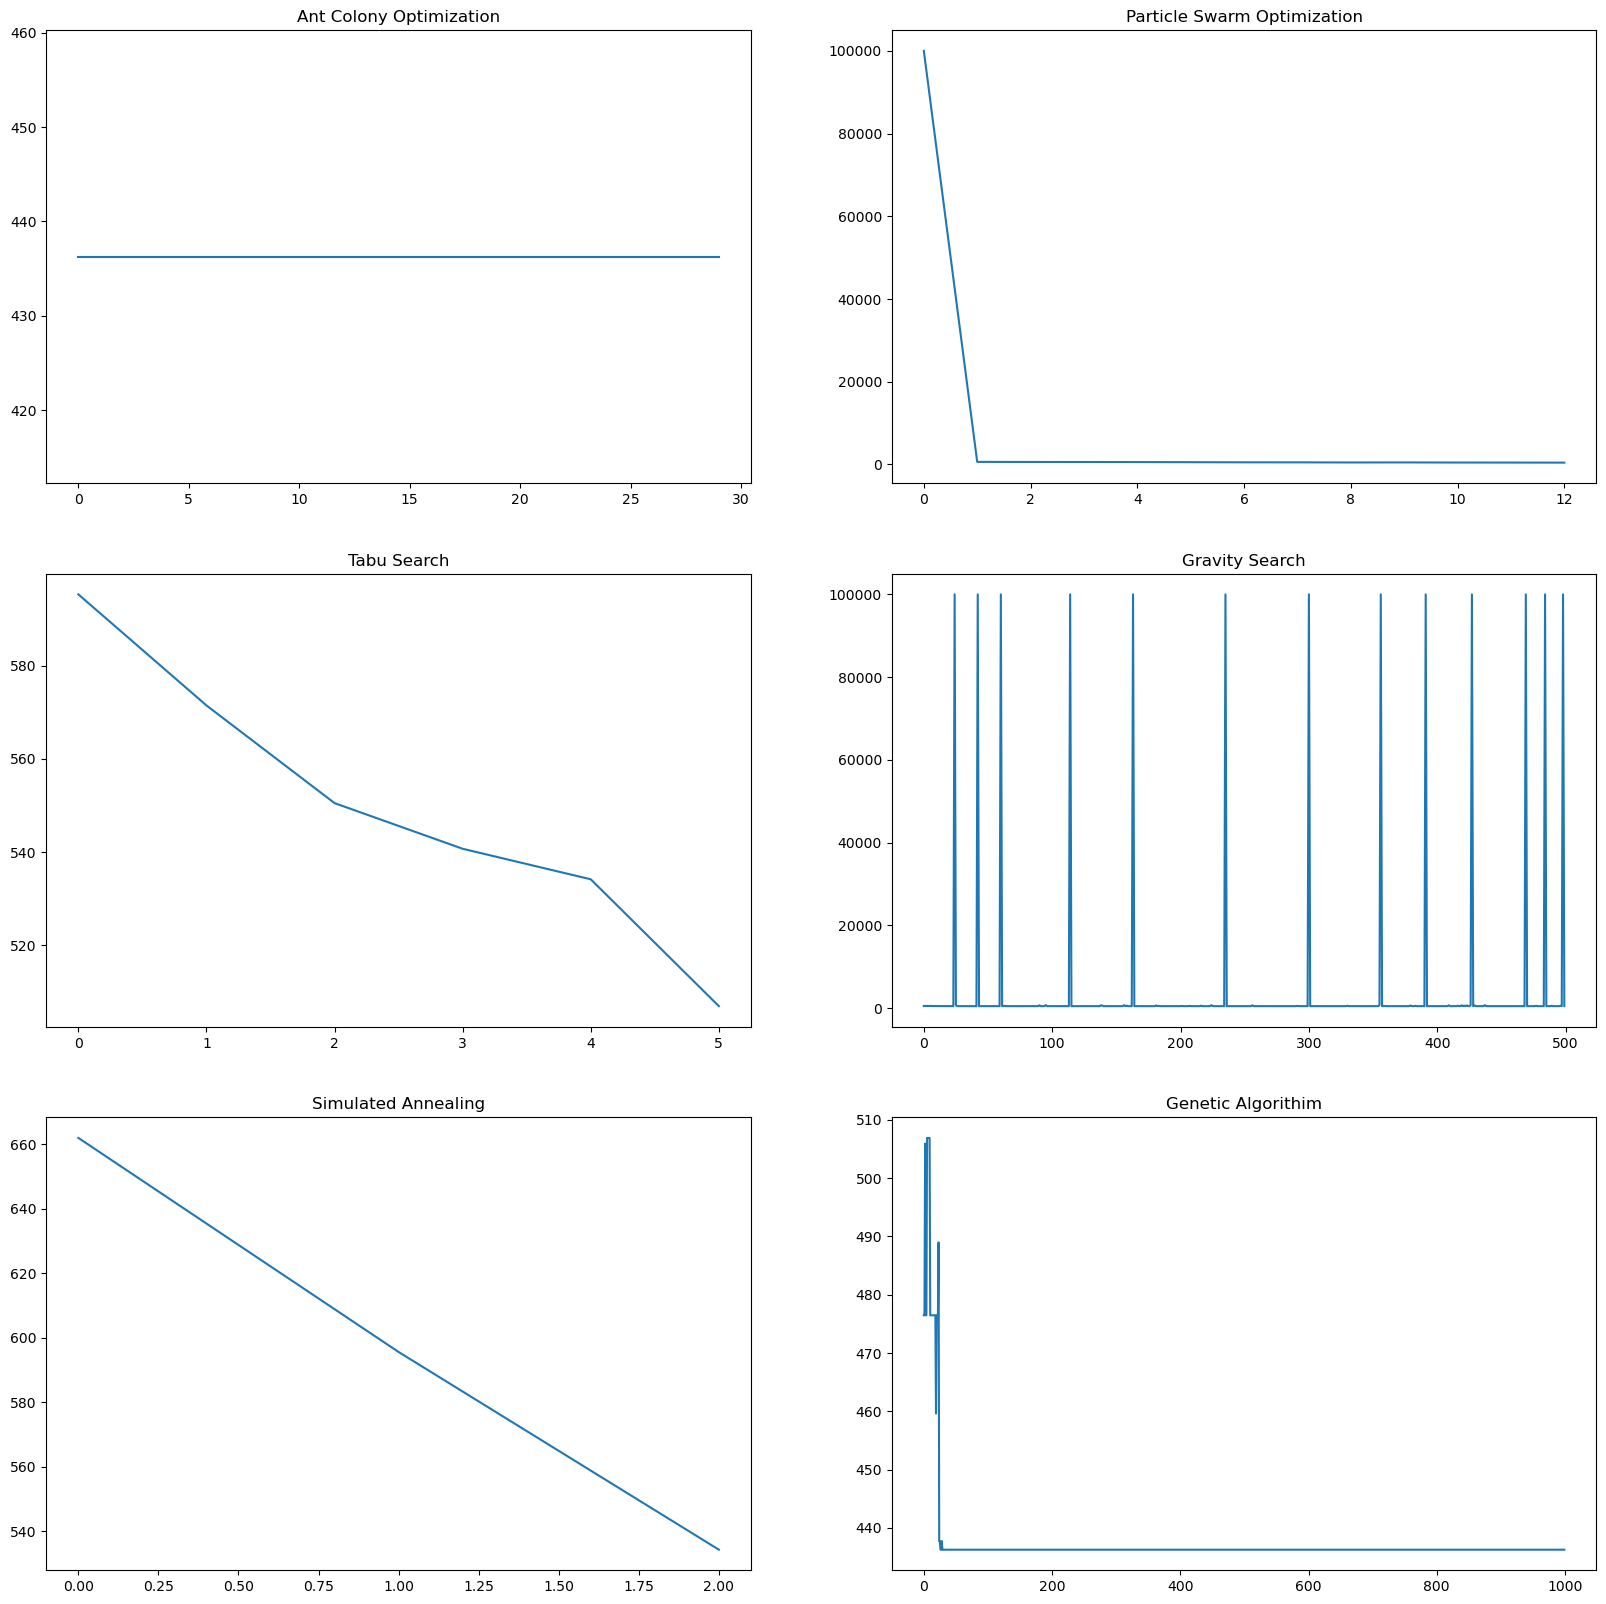

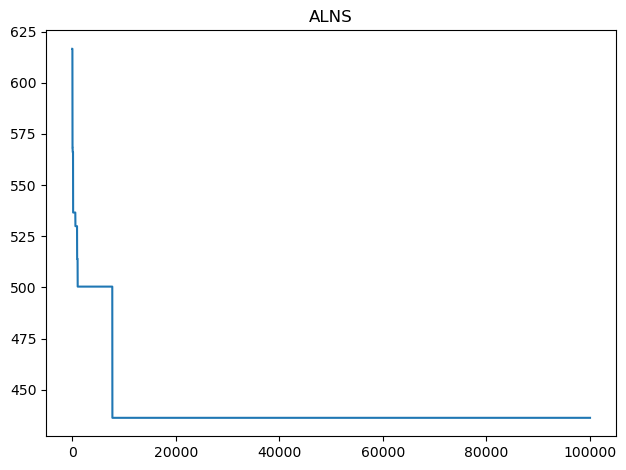

In [52]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

axs[0, 0].plot(ant_fit_hist)
axs[0, 0].set_title('Ant Colony Optimization')
axs[0, 1].plot(part_hist_list)
axs[0, 1].set_title('Particle Swarm Optimization')
axs[1, 0].plot(tabu_fit_hist)
axs[1, 0].set_title('Tabu Search')
axs[1, 1].plot(gravity_fit_his)
axs[1, 1].set_title('Gravity Search')
axs[2, 0].plot(sim_fit_his)
axs[2, 0].set_title('Simulated Annealing')
axs[2, 1].plot(genetic_his_list)
axs[2, 1].set_title('Genetic Algorithim')


if len(plot_fit) % 2 != 0:
    fig.delaxes(axs.flatten()[-1])

if len(plot_fit) > 0:
    plt.figure()
    plt.plot(plot_fit)
    plt.title('ALNS')

plt.tight_layout()
plt.show()

In [55]:
ant_refill = refillPosition_initial(antc_route,DEM,CS)
ant_fitness = all_times_calculation(antc_route,ant_refill)[0]
ant_refill_Ord = all_times_calculation(antc_route,ant_refill)[1]

particle_swarm_refill = refillPosition_initial(particle_swarm_solution,DEM,CS)
particle_fitness = all_times_calculation(particle_swarm_solution,particle_swarm_refill)[0]
particle_swarm_refill_Ord = all_times_calculation(particle_swarm_solution,particle_swarm_refill)[1]

tabu_refill = refillPosition_initial(tabu_solution,DEM,CS)
tabu_fitness = all_times_calculation(tabu_solution,tabu_refill)[0]
tabu_refill_Ord = all_times_calculation(tabu_solution,tabu_refill)[1]

gravity_search_refill = refillPosition_initial(gravity_solution,DEM,CS)
gravity_fitness = all_times_calculation(gravity_solution,gravity_search_refill)[0]
gravity_refill_Ord = all_times_calculation(gravity_solution,gravity_search_refill)[1]

simulated_annealing_refill = refillPosition_initial(simulated_route,DEM,CS)
simulated_annealing_fitness = all_times_calculation(simulated_route,simulated_annealing_refill)[0]
simulated_annealing_refill_Ord = all_times_calculation(simulated_route,simulated_annealing_refill)[1]

Genetic_refill = refillPosition_initial(Genetic_route,DEM,CS)
Genetic_fitness = all_times_calculation(Genetic_route,Genetic_refill)[0]
Genetic_refill_Ord = all_times_calculation(Genetic_route,Genetic_refill)[1]

ALNS_refill = refillPosition_initial(ALNS_route,DEM,CS)
ALNS_fitness = all_times_calculation(ALNS_route,ALNS_refill)[0]
ALNS_refill_Ord = all_times_calculation(ALNS_route,ALNS_refill)[1]

In [56]:
print("Ant Colony Optimization route:", antc_route)
print("Ant Colony Optimization nodes:", ant_refill_Ord)
print("Ant Colony Optimization fitness:", ant_fitness)
print()
print("Particle route:",particle_swarm_solution)
print("Particle refill nodes:",particle_swarm_refill_Ord)
print("Particle Objective:",particle_fitness)
print()
print("Tabu route:",tabu_solution)
print("Tabu refill nodes:",tabu_refill_Ord)
print("Tabu Objective:",tabu_fitness)
print()
print("Gravitational route:",gravity_solution)
print("Gravitational refill nodes:",gravity_refill_Ord)
print("Gravitational Objective:",gravity_fitness)
print()
print("simulated route:",simulated_route)
print("simulated refill nodes:",simulated_annealing_refill_Ord)
print("simulated objective:",simulated_annealing_fitness)
print()
print("Genetic route:",Genetic_route)
print("Genetic refill nodes:",Genetic_refill_Ord)
print("genetic objective:",Genetic_fitness)
print()
print("ALNS route:",ALNS_route)
print("ALNS refill nodes:",ALNS_refill_Ord)
print("ALNS Objective:",ALNS_fitness)
print()


Ant Colony Optimization route: [[0, 3, 4, 6, 0], [0, 8, 1, 2, 0], [0, 7, 5, 0]]
Ant Colony Optimization nodes: [8, 4]
Ant Colony Optimization fitness: 436.2598938025228

Particle route: [[0, 8, 1, 2, 0], [0, 4, 3, 6, 0], [0, 5, 7, 0]]
Particle refill nodes: [8, 3]
Particle Objective: 437.73154169283924

Tabu route: [[0, 7, 6, 3, 0], [0, 1, 8, 5, 0], [0, 4, 2, 0]]
Tabu refill nodes: [1, 6]
Tabu Objective: 506.8785846639371

Gravitational route: [[0, 8, 1, 2, 0], [0, 3, 4, 6, 0], [0, 7, 5, 0]]
Gravitational refill nodes: [8, 4]
Gravitational Objective: 436.2598938025228

simulated route: [[0, 4, 3, 5, 0], [0, 2, 1, 8, 0], [0, 6, 7, 0]]
simulated refill nodes: [3, 1]
simulated objective: 534.2213788783426

Genetic route: [[0, 3, 4, 6, 0], [0, 8, 1, 2, 0], [0, 5, 7, 0]]
Genetic refill nodes: [8, 4]
genetic objective: 436.2598938025228

ALNS route: [[0, 8, 1, 2, 0], [0, 3, 4, 6, 0], [0, 7, 5, 0]]
ALNS refill nodes: [8, 4]
ALNS Objective: 436.2598938025228



In [57]:
ant_route_pairs = create_route_pairs(ant_refill_Ord)
particle_swarm_pairs = create_route_pairs(particle_swarm_refill_Ord)
tabu_pairs = create_route_pairs(tabu_refill_Ord)
gravity_pairs = create_route_pairs(gravity_refill_Ord)
simulated_annealing_pairs = create_route_pairs(simulated_annealing_refill_Ord)
Genetic_pairs = create_route_pairs(Genetic_refill_Ord)
ALNS_pairs = create_route_pairs(ALNS_refill_Ord)

In [58]:
#GUROBI STARTS FROM HERE

In [59]:
CS=4

In [60]:
from gurobipy import Model, GRB, quicksum
m1=Model('Test')
x=m1.addVars(AK, vtype=GRB.BINARY)                   #Routing binary variable for sprayer
y=m1.addVars(A, vtype=GRB.BINARY)                   #Routing binary variable for tanker
v1=m1.addVars(A, vtype=GRB.BINARY)                  #Visualization for output plot                                   
z=m1.addVars(NTOT, vtype=GRB.BINARY)                #Binary variable for refill at node i
trout=m1.addVar( vtype=GRB.BINARY)
a=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #time of spraying start at i, also arrival time of sprayer at node i  

SC=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #Service completion time at node i

TW=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #Tanker waiting time at node i

TAN=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #Tanker arrival     

SPW=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #Sprayer wait         

tmax = m1.addVar(vtype=GRB.CONTINUOUS, name="tmax")


c=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #time of spraying start at i       
test=m1.addVar(vtype=GRB.CONTINUOUS, name="test")  
d=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #time of tanker arrival at i
g=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #sprayer level at entry to node i
h=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #quantity of fertilizer in tanker at i (NOT IMPLEMENTED - ASSUME TANKER HAS UNLIMITED CAPACITY)
ID=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)     #Waiting time at node i
alpha=m1.addVar(1, vtype=GRB.CONTINUOUS)            # latest arrival
dist_tanker = m1.addVar(vtype=GRB.CONTINUOUS, name="dist_tanker")
depot_arrival = m1.addVar(lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="depot_arrival")


testobj=m1.addVars(A, vtype=GRB.BINARY)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-05


In [63]:

    
# starting_solution = Genetic_route #to use genetic algortihm output as initial solution
# tanker_routing = Genetic_route_refill_nodes
# tanker_routing = Genetic_route_refill_nodes #Assign genetic refill output
# starting_solution = ALNS_route
starting_solution = Genetic_route



# starting_solution = simulated_route #to use simulated annealing solution as initial solution
# tanker_routing = simulated_route_node
tanker_routing=Genetic_refill_Ord

# tanker_routing = simulated_route_node #Assign Simulated Annealing refill output

# starting_solution = shuffled #Use to test custom solutions
# tanker_routing = refillPosition(starting_solution,DEM,CS) #Get refill for given solution


In [64]:
initial_solution = create_start_route(starting_solution) #with depot
# initial_solution = convert_routes(starting_solution)

print(initial_solution)

[(0, 3), (3, 4), (4, 6), (6, 0), (0, 8), (8, 1), (1, 2), (2, 0), (0, 5), (5, 7), (7, 0)]


In [65]:
tanker_routing

[8, 4]

In [70]:
if tanker_routing != []:

    route_pairs = create_route_pairs(tanker_routing)
    print(route_pairs)


[(0, 8), (4, 0), (8, 4)]


In [71]:
starting_solution,tanker_routing

([[0, 3, 4, 6, 0], [0, 8, 1, 2, 0], [0, 5, 7, 0]], [8, 4])

In [101]:
# #PRESCRIBE INITIAL SOLUTION HERE



# Calculate the number of elements to select (half the length of the full_solution list)
num_elements = len(initial_solution) // 2

# Randomly select half of the elements
half_solution = random.sample(initial_solution, num_elements)

# Calculate the number of elements to select (half the length of the full_solution list)
num_elements_t = len(route_pairs) // 2

# Randomly select half of the elements
half_solution_t = random.sample(route_pairs, num_elements_t)

# print(half_solution)


#SET INITIAL SOLUTION START

# for i, j in initial_solution: #Do not initiate when fertilizer number is greater than 2
#     x[i, j].start = 1
    
for i, j in half_solution:
    x[i, j].start = 1

if tanker_routing != []:
    for i in tanker_routing:
        z[i].start = 1
# if tanker_routing != []:    
#     for i, j in route_pairs: #Initialize this when using more than 2 fertilizers!
#         y[i, j].start = 1
    
for i, j in half_solution_t: #Initialize this when using more than 2 fertilizers!
    y[i, j].start = 1
    
# print(half_solution_t)

In [102]:
print('Number Of Farms = ', n)
print('Number Of Fertilizers = ', f)
print('Number Of Ssprayers = ', spn)


Number Of Farms =  8
Number Of Fertilizers =  2
Number Of Ssprayers =  3


In [103]:
from gurobipy import Model, GRB, quicksum
m1=Model('Test')
# x=m1.addVars(AK, vtype=GRB.BINARY)                   #Routing binary variable for sprayer

x=m1.addVars(A, vtype=GRB.BINARY)                   #Routing binary variable for sprayer


y=m1.addVars(A, vtype=GRB.BINARY)                   #Routing binary variable for tanker
v1=m1.addVars(A, vtype=GRB.BINARY)                  #Visualization for output plot                                   
z=m1.addVars(NTOT, vtype=GRB.BINARY)                #Binary variable for refill at node i
trout=m1.addVar( vtype=GRB.BINARY)
a=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #time of spraying start at i, also arrival time of sprayer at node i  

SC=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #Service completion time at node i

TW=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #Tanker waiting time at node i

TAN=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #Tanker arrival     

SPW=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #Sprayer wait         

tmax = m1.addVar(vtype=GRB.CONTINUOUS, name="tmax")


c=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #time of spraying start at i       
test=m1.addVar(vtype=GRB.CONTINUOUS, name="test")  
d=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #time of tanker arrival at i
g=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #sprayer level at entry to node i
h=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)      #quantity of fertilizer in tanker at i (NOT IMPLEMENTED - ASSUME TANKER HAS UNLIMITED CAPACITY)
ID=m1.addVars(NTOT, vtype=GRB.CONTINUOUS, lb=0)     #Waiting time at node i
alpha=m1.addVar(1, vtype=GRB.CONTINUOUS)            # latest arrival
dist_tanker = m1.addVar(vtype=GRB.CONTINUOUS, name="dist_tanker")
depot_arrival = m1.addVar(lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="depot_arrival")


testobj=m1.addVars(A, vtype=GRB.BINARY)

In [104]:
m1.modelSense = GRB.MINIMIZE
# m1.setObjective(alpha, GRB.MINIMIZE) #LATEST ARRIVAL TIME AT NODE
m1.setObjective(depot_arrival+sum(z[i] for i in N)+sum(SPW[i] for i in N)) #LATEST ARRIVAL AT DEPOT 
# m1.setObjective(alpha+depot_arrival+sum(y[i,j] for i in NTOT for j in NTOT if i!=j), GRB.MINIMIZE)
# m1.setObjective(alpha+sum(z[i] for i in N)) #LATEST ARRIVAL TIME AT NODE
# m1.setObjective(depot_arrival, GRB.MINIMIZE) #LATEST ARRIVAL AT DEPOT 



In [105]:
# m1.addConstr(tmax == tmax_value)

# m1.addConstrs(alpha >= SC[i] for i in N) #Latest node arrival 'alpha'



# m1.addConstrs(sum(x[i,j,k] for j in NTOT for k in K if j != i) == 1 for i in N)

# m1.addConstrs(sum(x[i,j,k] for i in NTOT for k in K if j != i) == 1 for j in N)


# m1.addConstrs(sum(x[i,j,k] for i in NTOT for j in NTOT if i != j) == 1 for k in K)

# m1.addConstrs(sum(x[i,j,k] for j in NTOT if j != i) == sum(x[i,l,k] for l in NTOT if l != i) for i in NTOT for k in K)

# m1.addConstrs(sum(x[0,i,k] for i in N) == 1 for k in K)

# m1.addConstrs(sum(x[i,0,k] for i in N) == 1 for k in K)










# m1.addConstrs(sum(x[i,j,k] for j in NTOT if j!=i) == 1 for i in N for k in K ) # each node visited once by some vehicle

# m1.addConstrs(sum(x[i,j,k] for j in NTOT if j!=i) == 1 for i in N for k in K ) 

# m1.addConstrs(sum(x[j,i,k] for j in NTOT for k in K if j!=i) - sum(x[i,j,k] for j in NTOT for k in K if j!=i) == 0 for i in NTOT for k in K) #entry exit sprayer for each vehicle

# m1.addConstrs(sum(x[0,i,k] for i in N) == 1 for k in K)

# m1.addConstr(sum(x[0,i,k] for i in N for k in K) == spn)
                          
# m1.addConstrs(sum(x[i,j] for j in NTOT if j!=i)==1 for i in N)     #each node visited once

# m1.addConstrs(sum(x[j,i] for j in NTOT if j!=i)-sum(x[i,j] for j in NTOT if j!=i)==0 for i in NTOT)    #entry exit sprayer

# m1.addConstr(sum(x[0,i,k] for i in N)-spn==0)            #number of sprayers





# m1.addConstr(sum(y[0,i] for i in N)-trout==0)            #number of tankers

# m1.addConstrs(z[i] <= trout for i in N)

# m1.addConstrs((sum(y[j,i] for j in NTOT if j!=i))-(sum(y[i,j] for j in NTOT if j!=i))==0 for i in NTOT )    #entry exit tanker

# m1.addConstrs(((SC[i]+SPW[i]+T[i,j])*x[i,j,k])+(z[i]*TS)+SER[j]-(M*(1-x[i,j,k]))<=(SC[j]) for k in K for i in NTOT for j in N if i!=j) #arrival time at next node

# m1.addConstrs(depot_arrival >= SC[i] + (T[i, 0] * x[i, 0, k]) for i in N for k in K )

# m1.addConstr(dist_tanker == sum(T[i, j] * y[i, j] for i in NTOT for j in NTOT if i != j))

# m1.addConstrs(sum(y[i, j] for j in N if j != i) <= sum(x[i, k,l] for l in K for k in N if k != i) for i in N)

# m1.addConstrs((TAN[j]>=(TAN[i]+TW[i]+TS+T[i,j])*y[i,j]-(M*(1-y[i,j]))) for i in NTOT for j in N if i!=j)    #tanker arrival at next node

# m1.addConstrs(TW[i]>=(SC[i]-TAN[i]) for i in NTOT)       #waiting time tanker

# m1.addConstrs(SPW[i]>=(TAN[i]-SC[i]) for i in NTOT)       #waiting time sprayer

# m1.addConstrs(g[j]<=g[i]-DEM[i]*x[i,j,k ]+CS*z[i]+M*(1-x[i,j,k]) for k in K for i in NTOT for j in N if i!=j)         #sprayer level

# m1.addConstrs(z[i]<=sum(y[j,i] for j in NTOT if j!=i) for i in N)        #refilling binary sets tanker route

# m1.addConstrs(((LG[i]-LG[j])*x[i,j, k]<=z[i] for k in K for i  in N for j in N if i!=j)) #multifertilizer refill condition

# m1.addConstrs(((LG[j]-LG[i])*x[i,j ,k ]<=z[i] for k in K for i  in N for j in N if i!=j)) #multifertilizer refill condition

# m1.addConstrs((g[i]>=x[0,i,k]*g[0])for k in K for i in N)    

# m1.addConstrs((g[i]>=DEM[i]) for i in N)

# m1.addConstrs((g[i]<=CS) for i in N)

# m1.addConstrs((h[i]<=CT) for i in N)

# m1.addConstrs((g[i]==CS) for i in {0})

# m1.addConstrs((h[i]==CT) for i in {0})

# m1.addConstrs((z[i]==0) for i in {0})





# m1.addConstrs((a[i]==0) for i in {0})

# m1.addConstrs((ID[i]==(d[i]-(a[i]+SER[i]))) for i in N)       #waiting time

# m1.addConstrs(h[j]<=(h[i]-(CS*(y[i,j]+y[0,j]))+(CT*y[0,j])+M*(1-y[i,j])) for i in N for j in N if i!=j) #tanker level

# m1.addConstrs(((c[j]>=(d[i])+(TS+T[i,j])*y[i,j]-(M*(1-y[i,j]))) for i in NTOT for j in N if i!=j))    #tanker arrival at next node

# m1.addConstrs(((a[i])+((SER[i]+T[i,j])*x[i,j])+(z[i]*TS)+ID[i]-(M*(1-x[i,j])))<=(a[j]) for i in NTOT for j in N if i!=j) #arrival time at next node

# m1.addConstrs(z[i] <= trout for i in N)

# m1.addConstr(sum(y[0,i] for i in N) - trout == 0)

# m1.addConstrs(SC[i] + T[i,j]*x[i,j] + TW[i] + SPW[i] <= tmax for i in NTOT for j in NTOT if i != j)

# m1.addConstr(sum(y[0,i] for i in N)-(trout*1)==0)

# m1.addConstr(sum(y[0,i] for i in N) <= 1)
# m1.addConstr(sum(y[0,i] for i in N) >= sum(z[i] for i in N))

# m1.addConstrs((a[i]>=x[0,i]*T[0,i]) for i in N) #initial nodes arrival (experimental)

# m1.addConstrs((d[i]>=c[i]) for i in N) #tanker service start 

# m1.addConstrs((c[i]>=a[i]) for i in N) #tanker arrival

In [106]:
# m1.addConstr(tmax == tmax_value)

m1.addConstrs(alpha >= SC[i] for i in N) #Latest node arrival 'alpha'
                          
m1.addConstrs(sum(x[i,j] for j in NTOT if j!=i)==1 for i in N)     #each node visited once

m1.addConstrs(sum(x[j,i] for j in NTOT if j!=i)-sum(x[i,j] for j in NTOT if j!=i)==0 for i in NTOT)    #entry exit sprayer

m1.addConstr(sum(x[0,i] for i in N)-spn==0)            #number of sprayers

m1.addConstr(sum(y[0,i] for i in N)-trout==0)            #number of tankers

m1.addConstrs(z[i] <= trout for i in N)

m1.addConstrs((sum(y[j,i] for j in NTOT if j!=i))-(sum(y[i,j] for j in NTOT if j!=i))==0 for i in NTOT )    #entry exit tanker

m1.addConstrs(((SC[i]+SPW[i]+T[i,j])*x[i,j])+(z[i]*TS)+SER[j]-(M*(1-x[i,j]))<=(SC[j]) for i in NTOT for j in N if i!=j) #arrival time at next node

m1.addConstrs(depot_arrival >= SC[i] + (T[i, 0] * x[i, 0]) for i in N )

m1.addConstr(dist_tanker == sum(T[i, j] * y[i, j] for i in NTOT for j in NTOT if i != j))

m1.addConstrs(sum(y[i, j] for j in N if j != i) <= sum(x[i, k] for k in N if k != i) for i in N)

m1.addConstrs((TAN[j]>=(TAN[i]+TW[i]+TS+T[i,j])*y[i,j]-(M*(1-y[i,j]))) for i in NTOT for j in N if i!=j)    #tanker arrival at next node

m1.addConstrs(TW[i]>=(SC[i]-TAN[i]) for i in NTOT)       #waiting time tanker

m1.addConstrs(SPW[i]>=(TAN[i]-SC[i]) for i in NTOT)       #waiting time sprayer

m1.addConstrs(g[j]<=g[i]-DEM[i]*x[i,j]+CS*z[i]+M*(1-x[i,j]) for i in NTOT for j in N if i!=j)   #sprayer level

m1.addConstrs(g[j]>=g[i]-DEM[i]*x[i,j]+CS*z[i]-M*(1-x[i,j]) for i in NTOT for j in N if i!=j)  #sprayer level consistency 

m1.addConstrs(z[i]<=sum(y[j,i] for j in NTOT if j!=i) for i in N)        #refilling binary sets tanker route

m1.addConstrs(((LG[i]-LG[j])*x[i,j]<=z[i] for i  in N for j in N if i!=j)) #multifertilizer refill condition

m1.addConstrs(((LG[j]-LG[i])*x[i,j]<=z[i] for i  in N for j in N if i!=j)) #multifertilizer refill condition

m1.addConstrs((g[i]>=x[0,i]*g[0]) for i in N)    

m1.addConstrs((g[i]>=DEM[i]) for i in N)

m1.addConstrs((g[i]<=CS) for i in N)

m1.addConstrs((h[i]<=CT) for i in N)

m1.addConstrs((g[i]==CS) for i in {0})

m1.addConstrs((h[i]==CT) for i in {0})

m1.addConstrs((z[i]==0) for i in {0})

m1.addConstrs(((SC[i]*x[i,0])+T[i,0]) <=tmax_value for i in N) 

{1: <gurobi.QConstr Not Yet Added>,
 2: <gurobi.QConstr Not Yet Added>,
 3: <gurobi.QConstr Not Yet Added>,
 4: <gurobi.QConstr Not Yet Added>,
 5: <gurobi.QConstr Not Yet Added>,
 6: <gurobi.QConstr Not Yet Added>,
 7: <gurobi.QConstr Not Yet Added>,
 8: <gurobi.QConstr Not Yet Added>}

In [107]:
alpha

<gurobi.Var *Awaiting Model Update*>

In [108]:
# m1.NumStart = 2
# m1.update()

# # iterate over all MIP starts
# for s in range(m1.NumStart):
  
#   # set StartNumber
#   m1.params.StartNumber = s

#   # now set MIP start values using the Start attribute, e.g.:
#   for v in model.getVars():
#     v.Start = <value>
    
#     starting_solution = Genetic_route #to use genetic algortihm output as initial solution
#     starting_solution = simulated_route #to use simulated annealing solution as initial solution
#     starting_solution = shuffled #to use simulated annealing solution as initial solution

In [109]:
m1.Params.TimeLimit = 3000
m1.Params.MIPFocus = 2
# m1.Params.OutputFlag= 1
m1.Params.StartNodeLimit = -1
# m1.tune()
m1.update()
m1.setParam('MIPFocus', 2)
# Now run the optimization
# m1.Params.Heuristics = 0.5


Set parameter TimeLimit to value 3000
Set parameter MIPFocus to value 2


In [110]:
m1.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7 CPU         980  @ 3.33GHz, instruction set [SSE2]
Thread count: 6 physical cores, 6 logical processors, using up to 6 threads

Optimize a model with 354 rows, 393 columns and 1451 nonzeros
Model fingerprint: 0xe30c773b
Model has 144 quadratic constraints
Variable types: 95 continuous, 298 integer (298 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
  QRHS range       [6e+02, 1e+04]
Presolve removed 180 rows and 195 columns
Presolve time: 0.01s
Presolved: 838 rows, 990 columns, 3191 nonzeros
Presolved model has 528 SOS constraint(s)
Variable types: 573 continuous, 417 integer (417 binary)
Root relaxation presolve removed 509 rows and 765 columns
Root relaxation presolved: 290 rows, 186 columns, 2121 nonzeros


Ro

In [86]:
#GET SPRAYER AND TANKER ARCS

# for i,j,k in AK:
#     v1[i,j,k]=x[i,j,k]
# yactive_arcs = [a for a in A if y[a].x > 0.99]   
# active_arcs = [a for a in AK if v1[a].x > 0.99]


In [87]:

for i,j in A:
    v1[i,j]=x[i,j]
yactive_arcs = [a for a in A if y[a].x > 0.99]   
active_arcs = [a for a in A if v1[a].x > 0.99]

In [88]:
active_arcs,SC

([(0, 2),
  (0, 3),
  (0, 7),
  (1, 8),
  (2, 1),
  (3, 4),
  (4, 6),
  (5, 0),
  (6, 0),
  (7, 5),
  (8, 0)],
 {0: <gurobi.Var C235 (value 0.0)>,
  1: <gurobi.Var C236 (value 366.19857455223865)>,
  2: <gurobi.Var C237 (value 180.59717307890605)>,
  3: <gurobi.Var C238 (value 132.57883196111675)>,
  4: <gurobi.Var C239 (value 227.6650936630632)>,
  5: <gurobi.Var C240 (value 433.02660971484926)>,
  6: <gurobi.Var C241 (value 401.3315531326006)>,
  7: <gurobi.Var C242 (value 253.0628678087075)>,
  8: <gurobi.Var C243 (value 464.46514263465457)>})

In [89]:
#GET ROUTES FROM ARCS

def getRoutes(active_arcs,t):
    counter = 0 # check how many routes from depot
    distanceTo = [0]*(n+1) # provide the distance to each node
    distanceFrom = [0]*(n+1) # provide the distance to each node
    for i in active_arcs:
        origin, destination = i
        distanceFrom[destination] = t[origin, destination]
        if origin == 0:
            counter = counter + 1
    routes = [[0]*1]*counter
    for i in range(counter):
        destination = active_arcs[i][1]
        distanceTo[destination] = t[0,destination]
        dummy = [0]
        while destination != 0:
            dummy.append(destination)
            for k in active_arcs:
                if k[0] == destination:
                    distanceTo[k[1]] = t[destination,k[1]]
                    destination = k[1]
                    break
        dummy.append(0)
        routes[i] = dummy
        for kk in range(1,len(dummy)-1):
            distanceFrom[dummy[kk]] = t[dummy[kk],dummy[kk+1]]
            
    distanceTo[0] = 0
    return routes ,distanceTo, distanceFrom

In [90]:
routes, distanceTo, distanceFrom = getRoutes(active_arcs,T)
yrouteso,ydistto,ydistfrom = getRoutes(yactive_arcs,T)
yroutes = [[element for element in sublist if element != 0] for sublist in yrouteso]


gurobi_route=routes

In [91]:
print("Gurobi route:",gurobi_route)
print("Gurobi refill nodes:",yroutes)
print("Gurobi Objective:",depot_arrival)
print()

Gurobi route: [[0, 2, 1, 8, 0], [0, 3, 4, 6, 0], [0, 7, 5, 0]]
Gurobi refill nodes: [[4, 1]]
Gurobi Objective: <gurobi.Var depot_arrival (value 510.4660156778694)>



In [92]:
SC[2],SC[6],SC[4],SC[3]

(<gurobi.Var C237 (value 180.59717307890605)>,
 <gurobi.Var C241 (value 401.3315531326006)>,
 <gurobi.Var C239 (value 227.6650936630632)>,
 <gurobi.Var C238 (value 132.57883196111675)>)

In [93]:
SC[5],SC[7],SC[8],SC[1]

(<gurobi.Var C240 (value 433.02660971484926)>,
 <gurobi.Var C242 (value 253.0628678087075)>,
 <gurobi.Var C243 (value 464.46514263465457)>,
 <gurobi.Var C236 (value 366.19857455223865)>)

In [94]:
SPW,TAN,TW

({0: <gurobi.Var C262 (value 0.0)>,
  1: <gurobi.Var C263 (value 1.7053025658242404e-13)>,
  2: <gurobi.Var C264 (value 0.0)>,
  3: <gurobi.Var C265 (value 0.0)>,
  4: <gurobi.Var C266 (value 0.0)>,
  5: <gurobi.Var C267 (value 0.0)>,
  6: <gurobi.Var C268 (value 0.0)>,
  7: <gurobi.Var C269 (value 0.0)>,
  8: <gurobi.Var C270 (value 0.0)>},
 {0: <gurobi.Var C253 (value 0.0)>,
  1: <gurobi.Var C254 (value 366.1985745522388)>,
  2: <gurobi.Var C255 (value 180.59717307890605)>,
  3: <gurobi.Var C256 (value 132.57883196111675)>,
  4: <gurobi.Var C257 (value 227.6650936630632)>,
  5: <gurobi.Var C258 (value 433.02660971484926)>,
  6: <gurobi.Var C259 (value 401.3315531326006)>,
  7: <gurobi.Var C260 (value 253.0628678087075)>,
  8: <gurobi.Var C261 (value 464.46514263465457)>},
 {0: <gurobi.Var C244 (value 0.0)>,
  1: <gurobi.Var C245 (value 0.0)>,
  2: <gurobi.Var C246 (value 0.0)>,
  3: <gurobi.Var C247 (value 0.0)>,
  4: <gurobi.Var C248 (value 0.0)>,
  5: <gurobi.Var C249 (value 0.0)>,

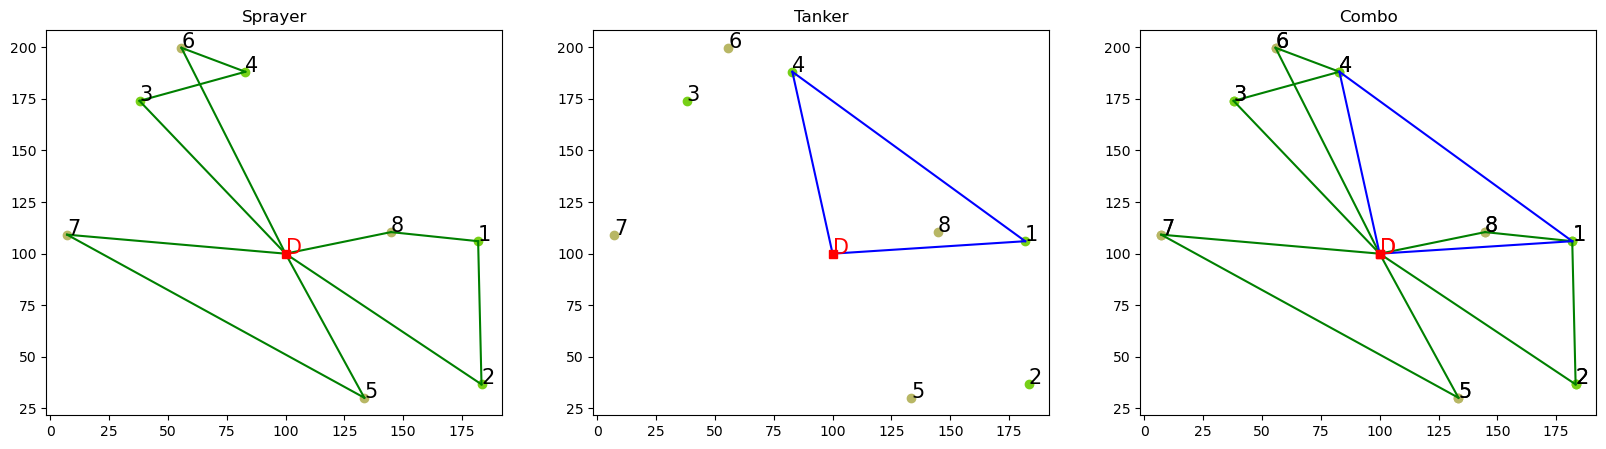

In [95]:
def plot_route_on_subplot(route, ax, line_color='g'):
    for sub_route in route:
        for i in range(len(sub_route) - 1):
            start = sub_route[i]
            end = sub_route[i + 1]
            ax.plot([xc[start], xc[end]], [yc[start], yc[end]], f'{line_color}-')

    ax.plot(xc[0], yc[0], c='r', marker='s')
    ax.annotate('D', (xc[0], yc[0]), fontsize=15, color='r')

    for i in range(len(splitsx)):
        ax.scatter(splitsx[i], splitsy[i], c=color[i])

    for i in N:
        ax.annotate('%d' % (i), (xc[i], yc[i]), fontsize=15 )

        
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_route_on_subplot(active_arcs, axes[0])
axes[0].set_title("Sprayer")

plot_route_on_subplot(yactive_arcs, axes[1], line_color='b')
axes[1].set_title("Tanker")

plot_route_on_subplot(active_arcs, axes[2])
axes[2].set_title("Combo")
plot_route_on_subplot(yactive_arcs, axes[2], line_color='b')

In [100]:
#ROUTES

routes, distanceTo, distanceFrom = getRoutes(active_arcs,T)
yrouteso,ydistto,ydistfrom = getRoutes(yactive_arcs,T)
yroutes = [[element for element in sublist if element != 0] for sublist in yrouteso]


gurobi_route=routes

print("simulated route:",simulated_route)
print("simulated refill nodes:",simulated_route_node)
print("simulated objective:",simulated_fitness)
print()
print("Genetic route:",Genetic_route)
print("Genetic refill nodes:",Genetic_route_refill_nodes)
print("genetic objective:",Genetic_fitness)
print()
print("Gurobi route:",gurobi_route)
print("Gurobi refill nodes:",yroutes)
print("Gurobi Objective:",depot_arrival)
print()
# print("Ant Colony Optimization route:", antc_route)
# print("Ant Colony Optimization nodes:", ant_colony_route)
# print("Ant Colony Optimization fitness:", ant_colony_f)
# print()
print("ALNS route:",ALNS_route)
print("ALNS refill nodes:",refillPosition_initial(ALNS_route,DEM,CS))
print("ALNS Objective:",nn_test(ALNS_route))
print()
print("Tabu route:",tabu_solution)
print("Tabu refill nodes:",refillPosition_initial(tabu_solution,DEM,CS))
print("Tabu Objective:",tabu_fitness)
print()
print("Particle route:",particle_swarm_solution)
print("Particle refill nodes:",refillPosition_initial(particle_swarm_solution,DEM,CS))
print("Particle Objective:",particle_fitness)
print()
print("Gravitational route:",gravity_solution)
print("Gravitational refill nodes:",refillPosition_initial(gravity_solution,DEM,CS))
print("Gravitational Objective:",gravity_fitness)
print()




simulated route: [[0, 4, 3, 5, 0], [0, 2, 1, 8, 0], [0, 6, 7, 0]]
simulated refill nodes: [3, 1]
simulated objective: 534.2213788783426

Genetic route: [[0, 3, 4, 6, 0], [0, 8, 1, 2, 0], [0, 5, 7, 0]]
Genetic refill nodes: [8, 4]
genetic objective: 436.2598938025228

Gurobi route: [[0, 2, 1, 8, 0], [0, 3, 4, 6, 0], [0, 7, 5, 0]]
Gurobi refill nodes: [[4, 1]]
Gurobi Objective: <gurobi.Var depot_arrival (value 510.4660156778694)>

ALNS route: [[0, 8, 1, 2, 0], [0, 3, 4, 6, 0], [0, 7, 5, 0]]
ALNS refill nodes: [8, 4]
ALNS Objective: 436.2598938025228

Tabu route: [[0, 7, 6, 3, 0], [0, 1, 8, 5, 0], [0, 4, 2, 0]]
Tabu refill nodes: [6, 1]
Tabu Objective: 506.8785846639371

Particle route: [[0, 8, 1, 2, 0], [0, 4, 3, 6, 0], [0, 5, 7, 0]]
Particle refill nodes: [8, 3]
Particle Objective: 437.73154169283924

Gravitational route: [[0, 8, 1, 2, 0], [0, 3, 4, 6, 0], [0, 7, 5, 0]]
Gravitational refill nodes: [8, 4]
Gravitational Objective: 436.2598938025228



In [97]:
y

{(0, 1): <gurobi.Var C72 (value -0.0)>,
 (0, 2): <gurobi.Var C73 (value -0.0)>,
 (0, 3): <gurobi.Var C74 (value 0.0)>,
 (0, 4): <gurobi.Var C75 (value 1.0)>,
 (0, 5): <gurobi.Var C76 (value -0.0)>,
 (0, 6): <gurobi.Var C77 (value -0.0)>,
 (0, 7): <gurobi.Var C78 (value -0.0)>,
 (0, 8): <gurobi.Var C79 (value -0.0)>,
 (1, 0): <gurobi.Var C80 (value 1.0)>,
 (1, 2): <gurobi.Var C81 (value -0.0)>,
 (1, 3): <gurobi.Var C82 (value -0.0)>,
 (1, 4): <gurobi.Var C83 (value -0.0)>,
 (1, 5): <gurobi.Var C84 (value -0.0)>,
 (1, 6): <gurobi.Var C85 (value -0.0)>,
 (1, 7): <gurobi.Var C86 (value -0.0)>,
 (1, 8): <gurobi.Var C87 (value -0.0)>,
 (2, 0): <gurobi.Var C88 (value -0.0)>,
 (2, 1): <gurobi.Var C89 (value -0.0)>,
 (2, 3): <gurobi.Var C90 (value -0.0)>,
 (2, 4): <gurobi.Var C91 (value -0.0)>,
 (2, 5): <gurobi.Var C92 (value -0.0)>,
 (2, 6): <gurobi.Var C93 (value -0.0)>,
 (2, 7): <gurobi.Var C94 (value 0.0)>,
 (2, 8): <gurobi.Var C95 (value -0.0)>,
 (3, 0): <gurobi.Var C96 (value -0.0)>,
 (3,

In [98]:

# Genetic_route_arr,_,_,_,_ = experiment(Genetic_route,Genetic_route_refill_nodes)
# simulated_route_arr,_,_,_,_ = experiment(simulated_route,simulated_route_node)
# gurobi_val_in_estimation_func,_,_,_,_=experiment(gurobi_route,xroutes)


# SC_values_only = [var.x for var in SC.values()]

# sorted_genetic_route_arr = {k: v for k, v in sorted(Genetic_route_arr.items(), key=lambda item: item[0])}
# sorted_simulated_route_arr = {k: v for k, v in sorted(simulated_route_arr.items(), key=lambda item: item[0])}
# sorted_gurobi_val_in_estimation_func = {k: v for k, v in sorted(gurobi_val_in_estimation_func.items(), key=lambda item: item[0])}



# sorted_genetic_route_from_func = {0: 0, **sorted_genetic_route_arr}
# sorted_simulated_from_func = {0: 0, **sorted_simulated_route_arr}
# sorted_gurobi_val_from_func = {0: 0, **sorted_gurobi_val_in_estimation_func}

# genetic_route_values = list(sorted_genetic_route_arr.values())
# simulated_route_values = list(sorted_simulated_route_arr.values())
# gurobi_func_vals = list(sorted_gurobi_val_from_func.values())



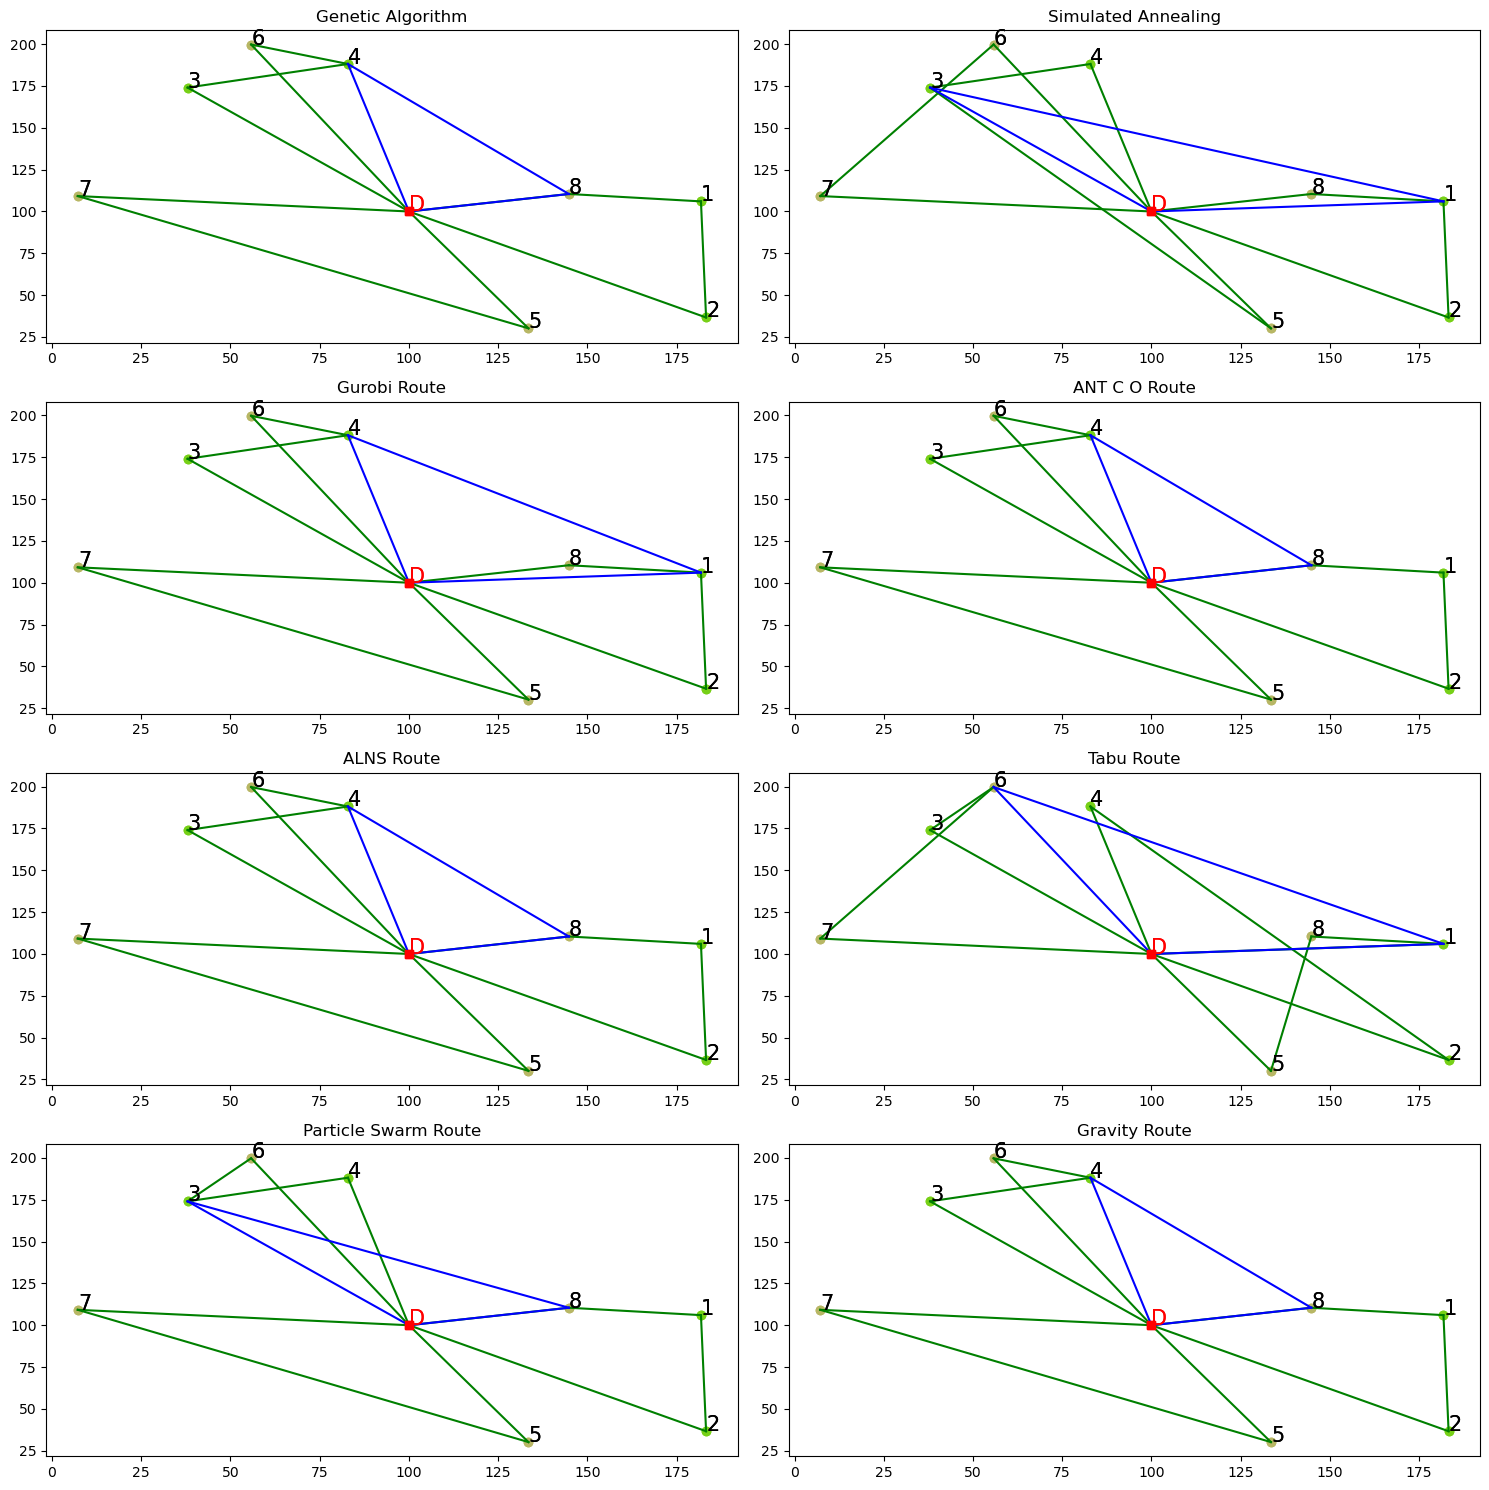

In [99]:
#PLOT COMPARISONS
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

plot_route_on_subplot(Genetic_route, axes[0, 0])
axes[0, 0].set_title("Genetic Algorithm")
plot_route_on_subplot(Genetic_pairs, axes[0, 0], line_color='b')

plot_route_on_subplot(simulated_route, axes[0, 1])
axes[0, 1].set_title("Simulated Annealing")
plot_route_on_subplot(simulated_annealing_pairs, axes[0, 1], line_color='b')

plot_route_on_subplot(gurobi_route, axes[1, 0])
axes[1, 0].set_title("Gurobi Route")
plot_route_on_subplot(yactive_arcs, axes[1, 0], line_color='b')

plot_route_on_subplot(antc_route, axes[1, 1])
axes[1, 1].set_title("ANT C O Route")
plot_route_on_subplot(ant_route_pairs, axes[1, 1], line_color='b')

plot_route_on_subplot(ALNS_route, axes[2, 0])
axes[2, 0].set_title("ALNS Route")
plot_route_on_subplot(ALNS_pairs, axes[2, 0], line_color='b')

plot_route_on_subplot(tabu_solution, axes[2, 1])
axes[2, 1].set_title("Tabu Route")
plot_route_on_subplot(tabu_pairs, axes[2, 1], line_color='b')

plot_route_on_subplot(particle_swarm_solution, axes[3, 0])
axes[3, 0].set_title("Particle Swarm Route")
plot_route_on_subplot(particle_swarm_pairs, axes[3, 0], line_color='b')

plot_route_on_subplot(gravity_solution, axes[3, 1])
axes[3, 1].set_title("Gravity Route")
plot_route_on_subplot(gravity_pairs, axes[3, 1], line_color='b')

plt.tight_layout()
plt.show()






In [ ]:
# from tabulate import tabulate


# table_data = list(zip(simulated_route_values,genetic_route_values,gurobi_func_vals,  SC_values_only, a))

# headers = [ "Simulated Annealing", "Genetic", "Manual Estimation of Gurobi Route",  "Gurobi output", "Node Number"]

# table = tabulate(table_data, headers=headers)

# title = "Service Completion Times for Sprayers"
# print(title)
# print("-" * len(title))  
# print(table)
